1. [Import libraries](#import-libraries)
2. [Loading dataset](#loading-dataset)
3. [Auxiliary functions](#auxiliary-functions)
4. [Preparing the datasets](#prep-datasets)
5. [Clustering on `AverageTemperature`](#avg-temperature)
    - [Checking the clusters to identify climate regions for boreal hemisphere](#boreal-regions)
    - [Checking the clusters to identify climate regions for austral hemisphere](#austral-regions)
    - [Assigning the labels](#labels)
    - [Spring](#spring)
    - [Summer](#summer)
    - [Autumn](#autumn)
    - [Winter](#winter)
6. [Clustering on `AverageTemperatureUncertainty`](#avg-temp-uncertainty)
    - [Boreal hemisphere](#boreal-regions-std)
    - [Austral hemisphere](#austral-regions-std)

## Importing libraries<a name="import-libraries"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

pp = pprint.PrettyPrinter(indent=2)

## Loading dataset<a name="loading-dataset"></a>

In [2]:
df_cities = pd.read_csv('data/CityGlobalTemperature2000-2009.csv', index_col=0)

In [3]:
df_cities

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time
1813,27.685,0.267,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-02-01
1814,29.061,0.224,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-03-01
1815,28.162,0.478,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-04-01
1816,27.547,0.509,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-05-01
1817,25.812,0.231,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-06-01
...,...,...,...,...,...,...,...
239128,18.459,0.374,Xian,China,34.56N,108.97E,2009-09-01
239129,14.195,0.163,Xian,China,34.56N,108.97E,2009-10-01
239130,2.916,0.675,Xian,China,34.56N,108.97E,2009-11-01
239131,-0.712,0.259,Xian,China,34.56N,108.97E,2009-12-01


## Auxiliary functions<a name="auxiliary-functions"></a>

In [4]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
city_infos_labels = ['City', 'Country', 'Latitude', 'Longitude', 'Year']

In [5]:
def plot_elbow(title, y_label, scores, ax):
    ax.plot(range(2, 8), scores, linestyle='-', marker='D', color='b');
    ax.set_xlabel('K');
    ax.set_ylabel(y_label);
    ax.set_xticks(range(2, 8, 1))
    ax.set_title(title);

In [6]:
def compute_scores(values):
    k_values = [2, 3, 4, 5, 6, 7]

    scores = []
    for k in k_values:
        km_euclidean = TimeSeriesKMeans(n_clusters=k, metric='euclidean', max_iter=20, random_state=69)
        km_euclidean.fit(values)

        km_dtw = TimeSeriesKMeans(n_clusters=k, metric='dtw', max_iter=20, random_state=69)
        km_dtw.fit(values)
            
        silhouette_euclidean = silhouette_score(values, km_euclidean.predict(values), metric='euclidean', n_jobs=-1, random_state=69)
        silhouette_dtw = silhouette_score(values, km_dtw.predict(values), metric='dtw', n_jobs=-1, random_state=69)

        scores.append([k, km_euclidean.inertia_, km_dtw.inertia_, silhouette_euclidean, silhouette_dtw])

    return scores

In [7]:
def plot_box_hemisphere(df, months, x_label, months_labels, plot_title):
    f, axes = plt.subplots(1, 3, figsize=(22, 7))
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    f.suptitle(plot_title)
    f.subplots_adjust(wspace=0.1)

    p = sns.boxplot(data=df, x=x_label, y=months[0], ax=axes[0])
    p.set(xlabel='Cluster label', ylabel=months_labels[0])
    p = sns.boxplot(data=df, x=x_label, y=months[1], ax=axes[1])
    p.set(xlabel='Cluster label', ylabel=months_labels[1])
    p = sns.boxplot(data=df, x=x_label, y=months[2], ax=axes[2])
    p.set(xlabel='Cluster label', ylabel=months_labels[2])

In [8]:
def plot_scores(df_results, plot_title):
    inertia_euclidean = df_results['EuclideanSSE']
    silhouette_euclidean = df_results['DTWSSE']
    inertia_dtw = df_results['EuclideanSilhouette']
    silhouette_dtw = df_results['DTWSilhouette']

    f, axes = plt.subplots(2, 2, figsize=(10, 10))
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(plot_title)
    f.subplots_adjust(wspace=0.2, hspace=0.2)

    plot_elbow('Inertia Euclidean Distance, max K = 7', 'Inertia', inertia_euclidean, ax=axes[0][0])
    plot_elbow('Silhouette Euclidean Distance, max K = 7', 'Silhouette', silhouette_euclidean, ax=axes[0][1])
    plot_elbow('Inertia DTW, max K = 7', 'Inertia', inertia_dtw, ax=axes[1][0])
    plot_elbow('Silhouette DTW, max K = 7', 'Silhouette', silhouette_dtw, ax=axes[1][1])

In [9]:
def plot_centroids(austral_centroids, 
                   boreal_centroids, 
                   legend_austral, 
                   legend_boreal):
    fig, axes = plt.subplots(1, 2, figsize=(20,7))

    plt.setp(axes, xticks=range(0, 12), xticklabels=months, ylabel='Average Temperature', xlabel='Month')

    axes[0].plot(austral_centroids.transpose(), label=legend_austral)
    axes[0].legend(loc="best")
    axes[0].set_title('Centroids for austral hemisphere')

    axes[1].plot(boreal_centroids.transpose(), label=legend_boreal)
    axes[1].legend(loc="best")
    axes[1].set_title('Centroids for boreal hemisphere')

    plt.show()

In [10]:
def plot_scatters(df, months, centroids, hue, hue_vals):
    g = sns.pairplot(
        df[[months[0], months[1], months[2], hue]], 
        hue=hue, 
        corner=True, 
        diag_kind="hist")
        
    g.data = centroids[[months[0], months[1], months[2], hue]]
    g.hue_vals = hue_vals
    g.map_offdiag(sns.scatterplot, s=300, marker="*", palette=['yellow' for h_val in hue_vals], edgecolor="black")

    plt.show()

In [11]:
def plot_city_counts(df, titles, clst_attribute, cluster_labels):
    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35, hspace=0.2)

    p = sns.countplot(y="City", data=df[df[clst_attribute] == cluster_labels[0]], ax=axes[0][0])
    p.set(xlabel='Number of measurements', title=titles[0])

    p = sns.countplot(y="City", data=df[df[clst_attribute] == cluster_labels[1]], ax=axes[0][1])
    p.set(xlabel='Number of measurements', title=titles[1])

    p = sns.countplot(y="City", data=df[df[clst_attribute] == cluster_labels[2]], ax=axes[1][0])
    p.set(xlabel='Number of measurements', title=titles[2])

    p = sns.countplot(y="City", data=df[df[clst_attribute] == cluster_labels[3]], ax=axes[1][1])
    p.set(xlabel='Number of measurements', title=titles[3])

In [12]:
def plot_country_counts(df, titles, clst_attribute, cluster_labels):
    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35, hspace=0.2)

    p = sns.countplot(y="Country", data=df[df[clst_attribute] == cluster_labels[0]], ax=axes[0][0])
    p.set(xlabel='Number of measurements', title=titles[0])

    p = sns.countplot(y="Country", data=df[df[clst_attribute] == cluster_labels[1]], ax=axes[0][1])
    p.set(xlabel='Number of measurements', title=titles[1])

    p = sns.countplot(y="Country", data=df[df[clst_attribute] == cluster_labels[2]], ax=axes[1][0])
    p.set(xlabel='Number of measurements', title=titles[2])

    p = sns.countplot(y="Country", data=df[df[clst_attribute] == cluster_labels[3]], ax=axes[1][1])
    p.set(xlabel='Number of measurements', title=titles[3])

In [13]:
def retrieve_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    l  = q1 - 1.5 * iqr
    u = q3 + 1.5 * iqr
    
    print(f"L: {l}")
    print(f"U: {u}")

    outliers = df[(df[col] < l) | (df[col] > u)]

    return outliers

## Preparing the datasets<a name="prep-datasets"></a>

In [14]:
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1813 to 239132
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             12000 non-null  float64
 1   AverageTemperatureUncertainty  12000 non-null  float64
 2   City                           12000 non-null  object 
 3   Country                        12000 non-null  object 
 4   Latitude                       12000 non-null  object 
 5   Longitude                      12000 non-null  object 
 6   time                           12000 non-null  object 
dtypes: float64(2), object(5)
memory usage: 750.0+ KB


We transform the attribute `time` to a `datetime` type so that we can extract easily month and year of the measurement

In [15]:
df_cities['time'] = pd.to_datetime(df_cities.time)

In [16]:
df_cities

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time
1813,27.685,0.267,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-02-01
1814,29.061,0.224,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-03-01
1815,28.162,0.478,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-04-01
1816,27.547,0.509,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-05-01
1817,25.812,0.231,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-06-01
...,...,...,...,...,...,...,...
239128,18.459,0.374,Xian,China,34.56N,108.97E,2009-09-01
239129,14.195,0.163,Xian,China,34.56N,108.97E,2009-10-01
239130,2.916,0.675,Xian,China,34.56N,108.97E,2009-11-01
239131,-0.712,0.259,Xian,China,34.56N,108.97E,2009-12-01


Just for plotting we consider only the year 2001 and only the cities that are in the boreal hemisphere.

In [17]:
df_2001 = df_cities[(df_cities['time'].dt.year == 2001) & (df_cities['Latitude'].str.contains('N'))]

In [18]:
df_2001 = df_2001.pivot_table(values='AverageTemperature', index=['City'], columns=['time'])
df_2001.reset_index(inplace=True)

In [19]:
temps_2001 = df_2001.drop(labels='City', axis=1)

([<matplotlib.axis.XTick at 0x7f622fc0d3d0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

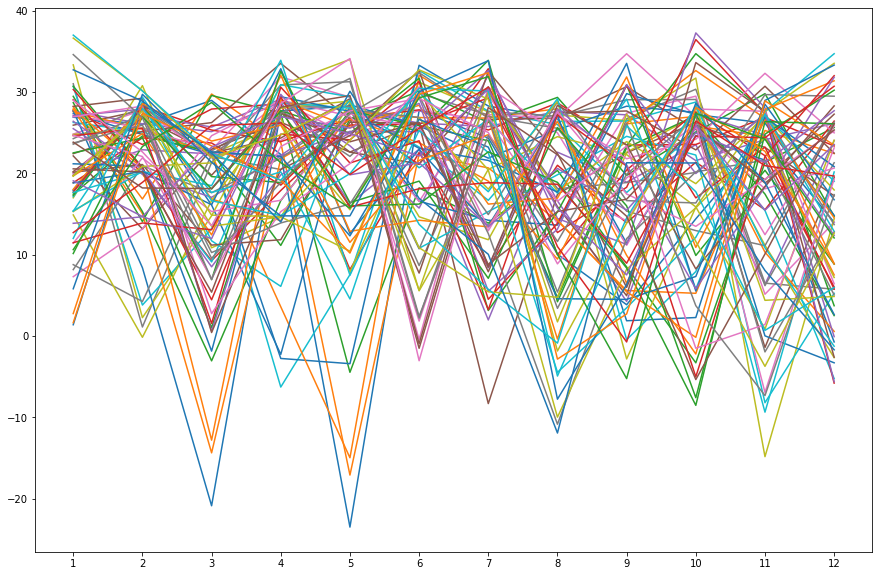

In [20]:
plt.figure(figsize=(15,10))
plt.plot(temps_2001.values.reshape(temps_2001.shape[1], temps_2001.shape[0]))
plt.xticks(range(0, 12, 1), months)

Exploiting the presence of the attribute `Latitude`, we create two different dataframe to distinguish between cities located in austral (south latitude) or boreal (north latitude) hemisphere. To do not lose the information about the year, we simply add a new attribute to keep track of it.

In [21]:
different_years = df_cities.time.dt.year.unique()
for year in different_years:
    df_cities.loc[df_cities.time.dt.year == year, 'Year'] = year

df_cities['time'] = df_cities.time.dt.month
df_cities_austral = df_cities[df_cities['Latitude'].str.contains('S')]
df_cities_boreal = df_cities[df_cities['Latitude'].str.contains('N')]

In [22]:
df_cities_austral

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time,Year
24336,23.617,0.271,Belo Horizonte,Brazil,20.09S,44.36W,2,2000.0
24337,23.052,0.185,Belo Horizonte,Brazil,20.09S,44.36W,3,2000.0
24338,21.899,0.131,Belo Horizonte,Brazil,20.09S,44.36W,4,2000.0
24339,19.990,0.232,Belo Horizonte,Brazil,20.09S,44.36W,5,2000.0
24340,18.741,0.567,Belo Horizonte,Brazil,20.09S,44.36W,6,2000.0
...,...,...,...,...,...,...,...,...
218589,17.426,0.150,Sydney,Australia,34.56S,151.78E,9,2009.0
218590,16.438,0.160,Sydney,Australia,34.56S,151.78E,10,2009.0
218591,20.261,0.273,Sydney,Australia,34.56S,151.78E,11,2009.0
218592,19.975,0.120,Sydney,Australia,34.56S,151.78E,12,2009.0


Now we create two different dataframes that will be used for clustering, one that represents the `AverageTemperature` and one that represent `AverageTemperatureUncertainty`. Both dataframes will have as attributes the month (represented as a number) of that measurement, the year and all the other information that describe the city and country.

In [23]:
df_avgtempsaustral_ts = df_cities_austral.pivot_table(values='AverageTemperature', index=city_infos_labels, columns='time')
df_avgtempsboreal_ts = df_cities_boreal.pivot_table(values='AverageTemperature', index=city_infos_labels, columns='time')
df_avgtempsaustral_ts.reset_index(inplace=True)
df_avgtempsboreal_ts.reset_index(inplace=True)

df_stdtempsaustral_ts = df_cities_austral.pivot_table(values='AverageTemperatureUncertainty', index=city_infos_labels, columns='time')
df_stdtempsboreal_ts = df_cities_boreal.pivot_table(values='AverageTemperatureUncertainty', index=city_infos_labels, columns='time')
df_stdtempsaustral_ts.reset_index(inplace=True)
df_stdtempsboreal_ts.reset_index(inplace=True)

In [24]:
df_avgtempsboreal_ts[df_avgtempsboreal_ts.isna().any(axis=1)]

time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12
0,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000.0,NaN,27.685,29.061,28.162,27.547,25.812,24.870,24.884,25.405,26.074,27.315,26.929
10,Abidjan,Côte D'Ivoire,5.63N,3.23W,2010.0,28.270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Addis Abeba,Ethiopia,8.84N,38.11E,2000.0,NaN,19.183,20.230,20.398,19.977,18.254,17.109,16.944,17.542,17.113,17.741,17.013
21,Addis Abeba,Ethiopia,8.84N,38.11E,2010.0,18.390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,Ahmadabad,India,23.31N,72.52E,2000.0,NaN,21.246,26.565,32.275,32.847,32.490,28.678,28.616,29.087,29.285,25.577,21.785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,Umm Durman,Sudan,15.27N,32.50E,2010.0,25.325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
869,Wuhan,China,29.74N,114.46E,2000.0,NaN,5.842,13.016,17.898,23.914,26.511,30.222,28.404,24.146,17.993,10.449,7.588
879,Wuhan,China,29.74N,114.46E,2010.0,5.478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,Xian,China,34.56N,108.97E,2000.0,NaN,0.943,8.997,13.714,20.568,22.387,25.578,22.517,17.823,11.116,4.095,1.265


For some cities in the year 2000 we miss the measurement for January, we assign to it the mean of the measurements for all the other year. For the year 2010 we got only the measurement for January so we will drop it.

In [25]:
df_avgtempsboreal_ts.loc[(df_avgtempsboreal_ts['Year'] == 2000) & (df_avgtempsboreal_ts[1].isna()), 1] = df_avgtempsboreal_ts.groupby(by='City')[1].transform('mean')
df_avgtempsaustral_ts.loc[(df_avgtempsaustral_ts['Year'] == 2000) & (df_avgtempsaustral_ts[1].isna()), 1] = df_avgtempsaustral_ts.groupby(by='City')[1].transform('mean')

df_stdtempsboreal_ts.loc[(df_stdtempsboreal_ts['Year'] == 2000) & (df_stdtempsboreal_ts[1].isna()), 1] = df_stdtempsboreal_ts.groupby(by='City')[1].transform('mean')
df_stdtempsaustral_ts.loc[(df_stdtempsaustral_ts['Year'] == 2000) & (df_stdtempsaustral_ts[1].isna()), 1] = df_stdtempsaustral_ts.groupby(by='City')[1].transform('mean')

In [26]:
n_rows_before_boreal = df_avgtempsboreal_ts.shape[0]
n_rows_before_austral = df_avgtempsaustral_ts.shape[0]
df_avgtempsaustral_ts.dropna(inplace=True)
df_avgtempsboreal_ts.dropna(inplace=True)
n_rows_after_austral = df_avgtempsaustral_ts.shape[0]
n_rows_after_boreal = df_avgtempsboreal_ts.shape[0]

print(f"Number of deleted rows {(n_rows_before_boreal - n_rows_after_boreal)+(n_rows_before_austral - n_rows_after_austral)} out of {n_rows_before_boreal+n_rows_before_austral}")
df_stdtempsaustral_ts.dropna(inplace=True)
df_stdtempsboreal_ts.dropna(inplace=True)

Number of deleted rows 100 out of 1100


In [27]:
df_stdtempsaustral_ts.values.shape

(190, 17)

In [28]:
df_stdtempsboreal_ts.values.shape

(810, 17)

In [29]:
df_avgtempsaustral_ts.values.shape

(190, 17)

In [30]:
df_avgtempsboreal_ts.values.shape

(810, 17)

We convert the dataframes to numpy arrays that will be used for clustering.

In [31]:
avgaustral_values = df_avgtempsaustral_ts.drop(labels=city_infos_labels, axis=1).values
avgboreal_values = df_avgtempsboreal_ts.drop(labels=city_infos_labels, axis=1).values
stdaustral_values = df_stdtempsaustral_ts.drop(labels=city_infos_labels, axis=1).values
stdboreal_values = df_stdtempsboreal_ts.drop(labels=city_infos_labels, axis=1).values

Now we normalize the data, for simplicity we declare a scaler for each array.

In [32]:
minmax_scaler_avgboreal = MinMaxScaler()
minmax_scaler_avgaustral = MinMaxScaler()
minmax_scaler_stdboreal = MinMaxScaler()
minmax_scaler_stdaustral = MinMaxScaler()

avgboreal_values_norm = minmax_scaler_avgboreal.fit_transform(avgboreal_values)
avgaustral_values_norm = minmax_scaler_avgaustral.fit_transform(avgaustral_values)

stdboreal_values_norm = minmax_scaler_stdboreal.fit_transform(stdboreal_values)
stdaustral_values_norm = minmax_scaler_stdaustral.fit_transform(stdaustral_values)

## Clustering on `AverageTemperature`<a name="avg-temperature"></a>

We compute silhouette and SSE for the euclidean and DTW metrics considering k in \[2, 7]

In [33]:
scores_boreal = compute_scores(to_time_series_dataset(avgboreal_values_norm))
scores_austral = compute_scores(to_time_series_dataset(avgaustral_values_norm))

In [34]:
df_avgtemps_ts_boreal_results = pd.DataFrame(scores_boreal, columns = ['K', 'EuclideanSSE', 'DTWSSE', 'EuclideanSilhouette', 'DTWSilhouette'])
df_avgtemps_ts_boreal_results.set_index(['K'], inplace=True)

df_avgtemps_ts_austral_results = pd.DataFrame(scores_austral, columns = ['K', 'EuclideanSSE', 'DTWSSE', 'EuclideanSilhouette', 'DTWSilhouette'])
df_avgtemps_ts_austral_results.set_index(['K'], inplace=True)

In [35]:
df_avgtemps_ts_boreal_results

,EuclideanSSE,DTWSSE,EuclideanSilhouette,DTWSilhouette
K,,,,
2,0.193828,0.101816,0.585272,0.646854
3,0.138004,0.071682,0.454864,0.490397
4,0.115827,0.054172,0.453033,0.399597
5,0.092795,0.045377,0.384547,0.417080
6,0.078129,0.035772,0.364390,0.424891
7,0.065127,0.033092,0.382033,0.343915


In [36]:
df_avgtemps_ts_austral_results

,EuclideanSSE,DTWSSE,EuclideanSilhouette,DTWSilhouette
K,,,,
2,0.221941,0.154606,0.589570,0.631064
3,0.146546,0.098015,0.495207,0.542610
4,0.050067,0.023594,0.586505,0.637587
5,0.041622,0.015328,0.564580,0.647575
6,0.027053,0.012943,0.531469,0.553720
7,0.023957,0.011601,0.501472,0.468711


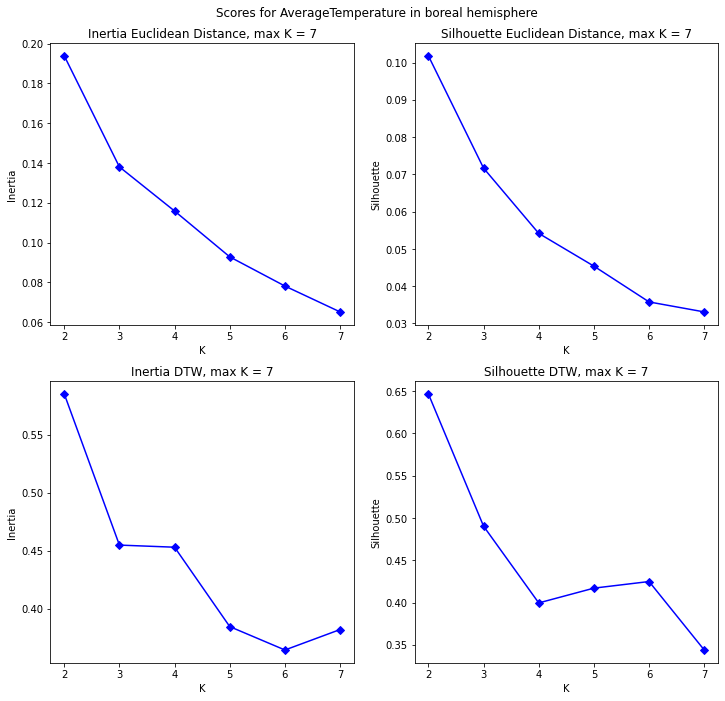

In [37]:
plot_scores(df_avgtemps_ts_boreal_results, "Scores for AverageTemperature in boreal hemisphere")

First of all we can see the difference for both the type of metrics because DTW seems to be more accurate both for SSE and silhouette but it is more heavy to compute than euclidean distance. Using the elbow method we choose `k = 4` to use for clustering cities inside the boreal hemisphere.

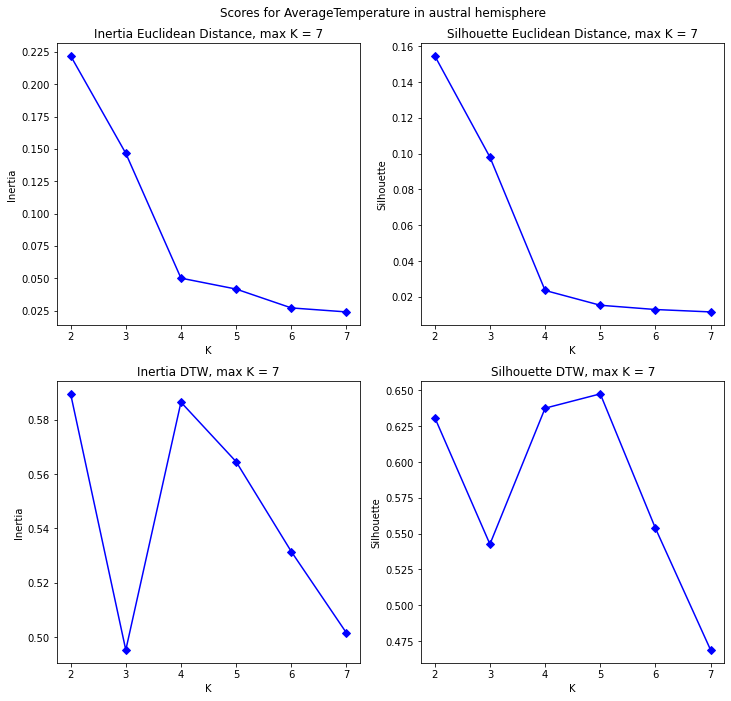

In [38]:
plot_scores(df_avgtemps_ts_austral_results, "Scores for AverageTemperature in austral hemisphere")

Also here considering the euclidean metric, for the SSE seems that the optimal value is `k = 4` but the silhouette is not very good. Considering DTW we see that for `k = 5` we get the best silhouette at the cost of a worse SSE.

Since it doesn't seems that we get too much advantage to use `k = 5`, we choose `k = 4` for the austral hemisphere. We choose this also because, as we will see later, for this value of k we spotted a possible city that got strange measurements that seemed like outliers.

In [39]:
tskm_avg_austral = TimeSeriesKMeans(n_clusters=4, metric='dtw', max_iter=20, random_state=69)
tskm_avg_austral.fit(to_time_series_dataset(avgaustral_values_norm))

TimeSeriesKMeans(max_iter=20, metric='dtw', n_clusters=4, random_state=69)

In [40]:
tskm_avg_boreal = TimeSeriesKMeans(n_clusters=4, metric='dtw', max_iter=20, random_state=69)
tskm_avg_boreal.fit(to_time_series_dataset(avgboreal_values_norm))

TimeSeriesKMeans(max_iter=20, metric='dtw', n_clusters=4, random_state=69)

In [41]:
centroids_avg_austral = minmax_scaler_avgaustral.inverse_transform(tskm_avg_austral.cluster_centers_.reshape((4, 12)))

print(centroids_avg_austral)

[[26.89146194 26.88640034 27.45593738 26.58553642 25.90650921 25.4650346
  24.86513741 25.6841217  27.99033062 27.62441999 27.65548506 26.09366662]
 [19.69606156 21.45631946 19.51781775 16.29917798 13.8155618  10.70667521
  10.38670638 10.54238671 13.14891602 14.46423852 17.32563541 18.42956   ]
 [23.09329081 24.42031762 23.62671489 22.8514134  21.33553685 20.48706925
  19.96759069 20.62646454 23.84579152 22.7873511  22.53481997 22.99192191]
 [13.0718781  12.35074403 10.0140744   5.98766631  2.54462539  0.91974013
  -0.47341158  0.96950345  2.42209763  5.81092228 10.15631237 11.73799773]]


In [42]:
centroids_avg_boreal = minmax_scaler_avgboreal.inverse_transform(tskm_avg_boreal.cluster_centers_.reshape((4, 12)))

print(centroids_avg_boreal)

[[-2.53650787 -3.6692117   1.81485202  9.42242877 12.66538607 18.65636483
  22.42749606 21.7051885  18.01501151 10.94361818  0.26064244 -0.94598142]
 [22.77823867 26.27446808 28.03796498 31.03062481 31.52731454 30.09453154
  30.11879277 26.24284601 26.10034099 26.23538827 23.21773719 24.61727125]
 [ 5.44006275 -0.98255759 10.19261208 15.54334081 21.78805923 23.52499713
  27.24360758 25.91800214 21.64198844 16.82235379  8.10473527  8.08595108]
 [13.84267035 12.83330601 20.26029348 26.04513192 29.68625537 33.44097733
  31.83256409 32.57959643 29.15591278 25.53893636 20.36147525 15.63757869]]


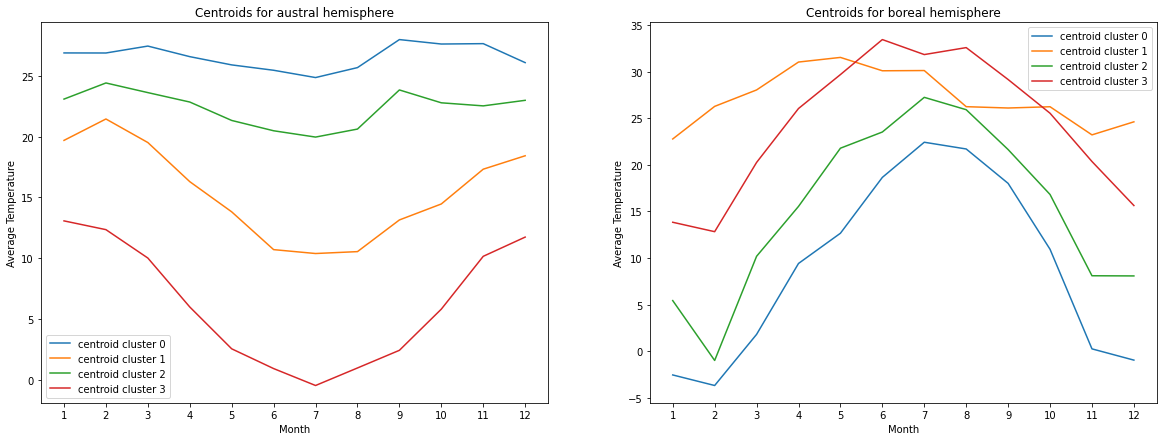

In [43]:
plot_centroids(centroids_avg_austral, 
               centroids_avg_boreal, 
               ['centroid cluster 0', 'centroid cluster 1', 'centroid cluster 2', 'centroid cluster 3'],
               ['centroid cluster 0', 'centroid cluster 1', 'centroid cluster 2', 'centroid cluster 3'])

In [44]:
df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] = tskm_avg_boreal.predict(to_time_series_dataset(avgboreal_values_norm))
df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] = tskm_avg_austral.predict(to_time_series_dataset(avgaustral_values_norm))

### Checking the clusters to identify climate regions for boreal hemisphere<a name="boreal-regions"></a>

In [45]:
df_avgtempsboreal_ts[df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 3]['City'].unique()

array(['Alexandria', 'Baghdad', 'Cairo', 'Delhi', 'Faisalabad', 'Gizeh',
       'Guangzhou', 'Jaipur', 'Kanpur', 'Lahore', 'Lakhnau', 'New Delhi',
       'Riyadh', 'Taipei'], dtype=object)

As we can see in this cluster there are mostly cities where the climate is semi-arid. We will identify these cities inside the `Semi-arid climate` region.

In [46]:
df_avgtempsboreal_ts[df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 0]['City'].unique()

array(['Ankara', 'Berlin', 'Changchun', 'Chengdu', 'Chicago', 'Dalian',
       'Harbin', 'Kiev', 'London', 'Madrid', 'Montreal', 'Moscow',
       'New York', 'Paris', 'Peking', 'Saint Petersburg', 'Seoul',
       'Shenyang', 'Taiyuan', 'Tangshan', 'Tianjin', 'Toronto', 'Xian'],
      dtype=object)

In these cities the temperature is very cold, we can identify them inside the `Cold continental climate` region.

In [47]:
df_avgtempsboreal_ts[df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 2]['City'].unique()

array(['Addis Abeba', 'Aleppo', 'Casablanca', 'Chongqing', 'Istanbul',
       'Izmir', 'Jinan', 'Kabul', 'Los Angeles', 'Madrid', 'Mashhad',
       'Mexico', 'Nagoya', 'Nanjing', 'New York', 'Peking', 'Rome',
       'Seoul', 'Shanghai', 'Tangshan', 'Tianjin', 'Tokyo', 'Wuhan'],
      dtype=object)

These cities spans from mediterranean like temperatures (Los Angeles, Madrid, ...) to more humid-continental temperatures. We can identify them inside the `Temperate climate` region.

In [48]:
df_avgtempsboreal_ts[df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 1]['City'].unique()

array(['Abidjan', 'Ahmadabad', 'Bangalore', 'Bangkok', 'Bogotá', 'Bombay',
       'Calcutta', 'Cali', 'Dakar', 'Dhaka', 'Ho Chi Minh City',
       'Hyderabad', 'Ibadan', 'Jiddah', 'Kano', 'Karachi', 'Lagos',
       'Madras', 'Manila', 'Mogadishu', 'Nagpur', 'Pune', 'Rangoon',
       'Santo Domingo', 'Singapore', 'Surat', 'Umm Durman'], dtype=object)

These are cities located in the tropical parth of our globe, in fact we can see that their centroid have a mean temperature that is almost equal for each months (so we can expect low standard deviation). 

We can also see that there are cities where there are measurements that belongs to the temperate and continental climate (like New York).

### Checking the clusters to identify climate regions for austral hemisphere<a name="austral-hemisphere"></a>

For the austral hemisphere we can expect similar results.

In [49]:
df_avgtempsaustral_ts[df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 2]['City'].unique()

array(['Belo Horizonte', 'Brasília', 'Durban', 'Harare', 'Kinshasa',
       'Rio De Janeiro', 'São Paulo'], dtype=object)

These are cities that have a more mild climate than tropical ones (more defined winter) but still they have high humidity levels. We can assign them to the `Sub-tropical climate` region.

In [50]:
df_avgtempsaustral_ts[df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 1]['City'].unique()

array(['Cape Town', 'Lima', 'Melbourne', 'Nairobi', 'Sydney'],
      dtype=object)

As before, these are cities that have well defined winters and summers so we assign them to the `Temperate climate` region.

In [51]:
df_avgtempsaustral_ts[df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 0]['City'].unique()

array(['Dar Es Salaam', 'Fortaleza', 'Jakarta', 'Kinshasa', 'Luanda',
       'Rio De Janeiro', 'Salvador', 'Surabaya'], dtype=object)

These cities have generally tropical climate. We assign them to the `Tropical region` climate.

In [52]:
df_avgtempsaustral_ts[df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 3]['City'].unique()

array(['Santiago'], dtype=object)

This cluster contains only one city (Santiago, capital of Chile) and it was the reason for which we got a bad silhouette score for `k = 3`. We investigated the values for each year.

In [53]:
df_avgtempsaustral_ts[df_avgtempsaustral_ts['City'] == 'Santiago']

time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
165,Santiago,Chile,32.95S,69.89W,2000.0,13.1785,11.470,9.389,6.735,2.347,0.458,-1.403,0.992,2.464,5.927,8.461,12.089,3
166,Santiago,Chile,32.95S,69.89W,2001.0,12.9470,13.548,10.593,6.024,2.306,-0.195,0.145,1.887,2.358,6.143,8.930,12.290,3
167,Santiago,Chile,32.95S,69.89W,2002.0,12.4380,11.682,10.917,6.186,3.586,-1.452,-0.369,1.769,3.712,6.425,9.240,10.869,3
168,Santiago,Chile,32.95S,69.89W,2003.0,13.4700,12.154,10.753,6.344,3.041,1.998,-0.750,0.688,4.106,7.969,10.448,11.066,3
169,Santiago,Chile,32.95S,69.89W,2004.0,13.3770,11.655,11.395,6.892,0.971,0.315,-0.480,1.184,4.136,5.820,8.414,12.117,3
170,Santiago,Chile,32.95S,69.89W,2005.0,12.7760,12.348,10.151,5.706,2.421,0.970,-0.175,1.179,1.982,5.333,10.185,11.793,3
171,Santiago,Chile,32.95S,69.89W,2006.0,13.7750,12.347,9.843,6.721,2.808,1.357,1.300,1.773,3.900,7.008,9.189,12.046,3
172,Santiago,Chile,32.95S,69.89W,2007.0,12.9380,11.625,9.894,6.190,1.029,-1.684,-1.915,-2.222,2.813,6.398,9.331,11.734,3
173,Santiago,Chile,32.95S,69.89W,2008.0,13.2300,12.526,10.527,6.545,2.865,-1.070,0.257,1.175,3.207,6.451,10.832,12.267,3
174,Santiago,Chile,32.95S,69.89W,2009.0,13.0460,12.770,11.870,8.686,3.934,0.028,-1.139,2.283,1.684,6.597,9.138,11.549,3


These values are really strange because this city should have a more mild climate (https://en.wikipedia.org/wiki/Santiago#Climate). 

A possible explanation of these values, other than a possible error from the meteorological station, is the possibility that the station was collocated in a position near the eastern tundra of Chile. We assign these measurements to the `Tundra climate` region. Searching for these coordinates lead us to a mountainous territory so it is possible to have this measurements.

Metereological map of Chile: https://upload.wikimedia.org/wikipedia/commons/f/ff/Chile_K%C3%B6ppen.png

Position of Santiago in map: https://upload.wikimedia.org/wikipedia/commons/7/7b/Arquidi%C3%B3cesis_de_Santiago_de_Chile.svg

### Assigning the labels<a name="labels"></a>

Given these results, we identify the centroids with following regions for the boreal hemisphere:
- Centroid 0: Cold continental climate.
- Centroid 1: Tropical climate.
- Centroid 2: Temperate climate.
- Centroid 3: Semi-arid climate.

For the austral hemisphere:
- Centroid 0: Tropical climate.
- Centroid 1: Temperate climate.
- Centroid 2: Sub-tropical climate.
- Centroid 3: Tundra climate.

In [54]:
boreal_labels = ['Cold continental', 'Tropical', 'Temperate', 'Semi-arid']
austral_labels = ['Tropical', 'Temperate', 'Sub-tropical', 'Tundra']

For a better understanding, we plot again the centroids with the updated labels.

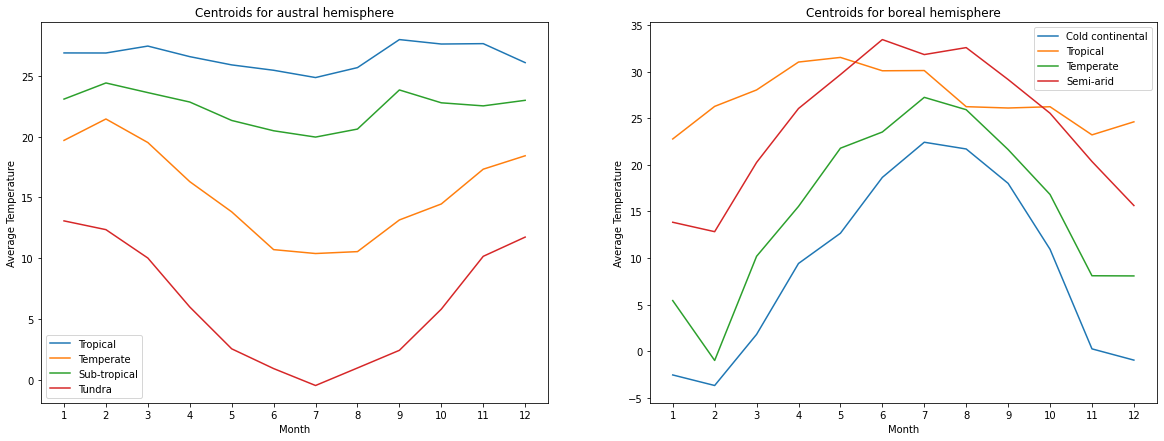

In [55]:
plot_centroids(centroids_avg_austral, centroids_avg_boreal, austral_labels, boreal_labels)

We update now these labels to better understand the following plots. 

In [56]:
df_avgtempsboreal_ts.loc[df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 0, 'TimeSeriesKMeansLabelAvg'] = boreal_labels[0]
df_avgtempsboreal_ts.loc[df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 1, 'TimeSeriesKMeansLabelAvg'] = boreal_labels[1]
df_avgtempsboreal_ts.loc[df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 2, 'TimeSeriesKMeansLabelAvg'] = boreal_labels[2]
df_avgtempsboreal_ts.loc[df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 3, 'TimeSeriesKMeansLabelAvg'] = boreal_labels[3]

df_avgtempsaustral_ts.loc[df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 0, 'TimeSeriesKMeansLabelAvg'] = austral_labels[0]
df_avgtempsaustral_ts.loc[df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 1, 'TimeSeriesKMeansLabelAvg'] = austral_labels[1]
df_avgtempsaustral_ts.loc[df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 2, 'TimeSeriesKMeansLabelAvg'] = austral_labels[2]
df_avgtempsaustral_ts.loc[df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 3, 'TimeSeriesKMeansLabelAvg'] = austral_labels[3]

[Text(0.5, 24.0, 'Cluster label'),
 Text(643.5431818181817, 0.5, 'Number of measurements'),
 Text(0.5, 1.0, 'Austral hemisphere')]

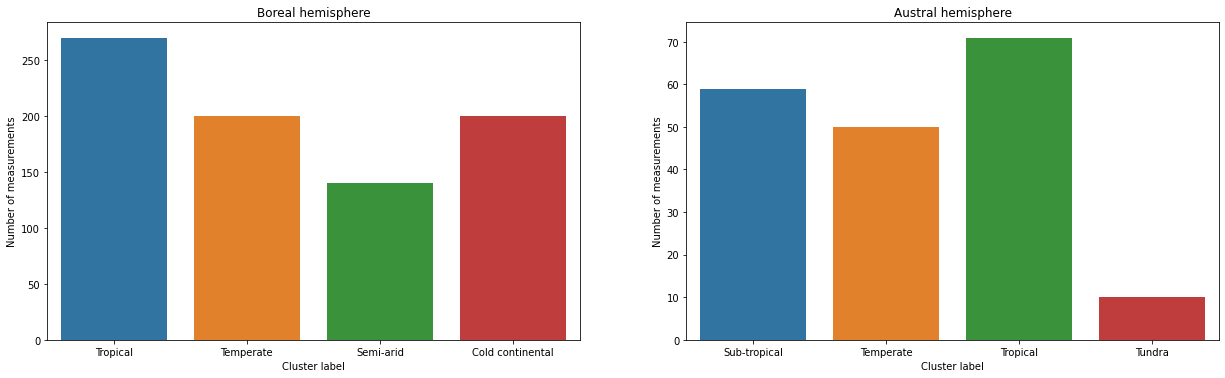

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

fig.tight_layout()
fig.subplots_adjust(wspace=0.2)

p = sns.countplot(x='TimeSeriesKMeansLabelAvg', data=df_avgtempsboreal_ts, ax=axes[0])
p.set(xlabel='Cluster label', ylabel='Number of measurements', title='Boreal hemisphere')
p= sns.countplot(x='TimeSeriesKMeansLabelAvg', data=df_avgtempsaustral_ts, ax=axes[1])
p.set(xlabel='Cluster label', ylabel='Number of measurements', title='Austral hemisphere')

<Figure size 504x504 with 0 Axes>

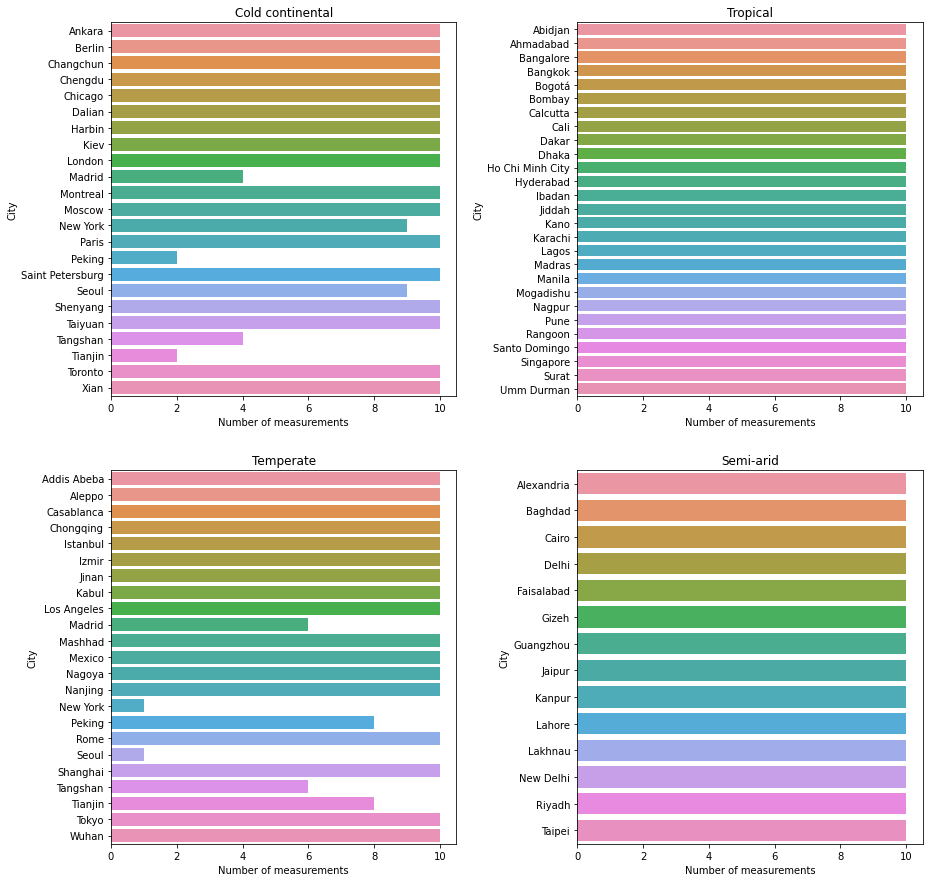

In [58]:
plt.figure(figsize=(7,7))
plot_city_counts(df_avgtempsboreal_ts, boreal_labels, 'TimeSeriesKMeansLabelAvg', boreal_labels)

We can see that there are cities in which there were measurements in both Temperate and Cold continental regions. We consider as an example the city of New York.

In [59]:
df_avgtempsboreal_ts[df_avgtempsboreal_ts['City'] == 'New York']

time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
638,New York,United States,40.99N,74.56W,2000.0,-2.2993,-0.162,6.391,8.897,15.944,20.234,20.727,20.791,17.095,11.323,4.913,-3.356,Cold continental
639,New York,United States,40.99N,74.56W,2001.0,-2.8140,-0.442,1.884,9.920,16.014,20.907,21.045,23.507,17.474,11.990,8.212,3.475,Cold continental
640,New York,United States,40.99N,74.56W,2002.0,1.2520,2.126,4.677,11.125,14.171,20.623,23.931,23.558,19.125,10.446,4.945,-0.953,Cold continental
641,New York,United States,40.99N,74.56W,2003.0,-5.2230,-3.786,3.526,8.185,13.817,18.960,22.864,23.243,18.262,10.202,7.603,0.379,Cold continental
642,New York,United States,40.99N,74.56W,2004.0,-6.3250,-1.332,4.525,10.057,17.800,19.761,21.946,21.771,18.843,10.960,6.682,-0.014,Cold continental
643,New York,United States,40.99N,74.56W,2005.0,-3.6110,-0.609,1.125,10.633,13.267,22.169,23.704,23.941,20.238,12.058,7.019,-1.757,Cold continental
644,New York,United States,40.99N,74.56W,2006.0,1.6080,-0.565,3.776,10.709,15.637,20.445,24.165,22.420,16.946,10.811,8.418,3.861,Temperate
645,New York,United States,40.99N,74.56W,2007.0,0.4120,-4.713,2.947,8.020,16.677,20.868,22.295,22.063,19.000,15.222,4.831,-0.094,Cold continental
646,New York,United States,40.99N,74.56W,2008.0,-0.5730,-0.675,3.470,10.943,13.640,21.831,23.693,20.887,18.676,10.348,5.133,0.327,Cold continental
647,New York,United States,40.99N,74.56W,2009.0,-5.3600,-0.372,3.579,10.478,15.447,19.058,21.103,22.769,17.043,10.364,8.217,-0.624,Cold continental


We can see that the year 2006 was the warmest for New York and so it was classified like a temperate climate.

<Figure size 504x504 with 0 Axes>

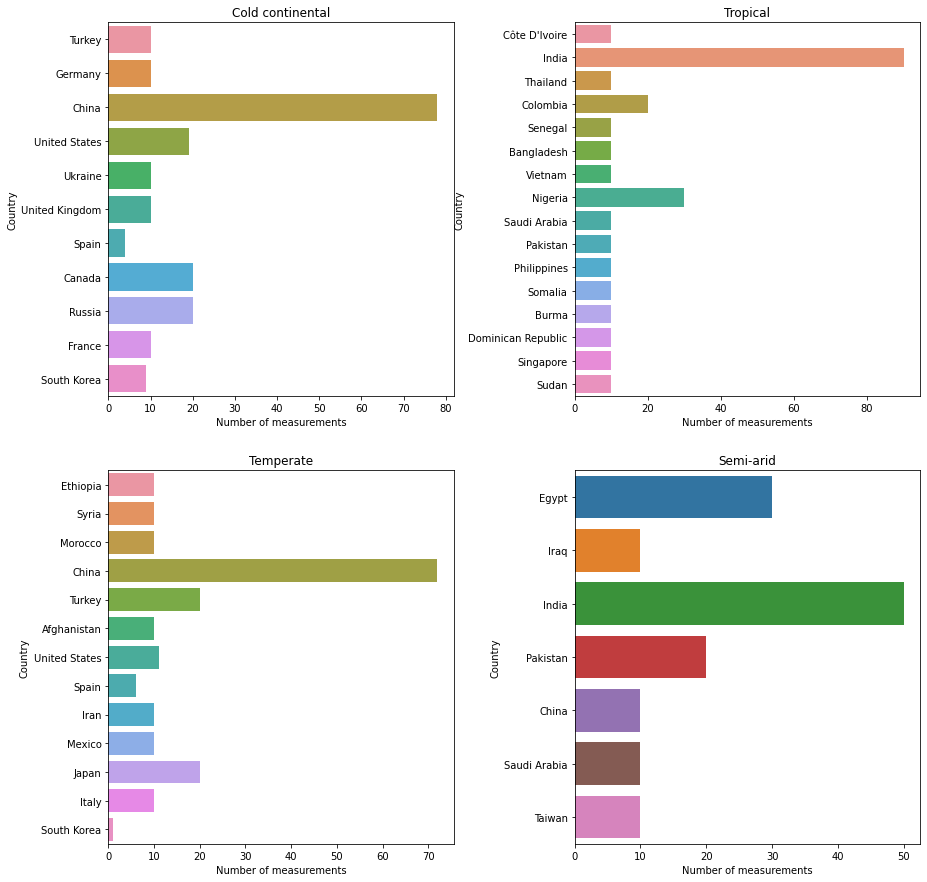

In [60]:
plt.figure(figsize=(7,7))
plot_country_counts(df_avgtempsboreal_ts, boreal_labels, 'TimeSeriesKMeansLabelAvg', boreal_labels)

As we can see there are regions in which the number of measurements is higher than the other, this is due to the presence of more metereological station. This allowed us to spot, for big countries like China or India, two internal climate regions.

<Figure size 504x504 with 0 Axes>

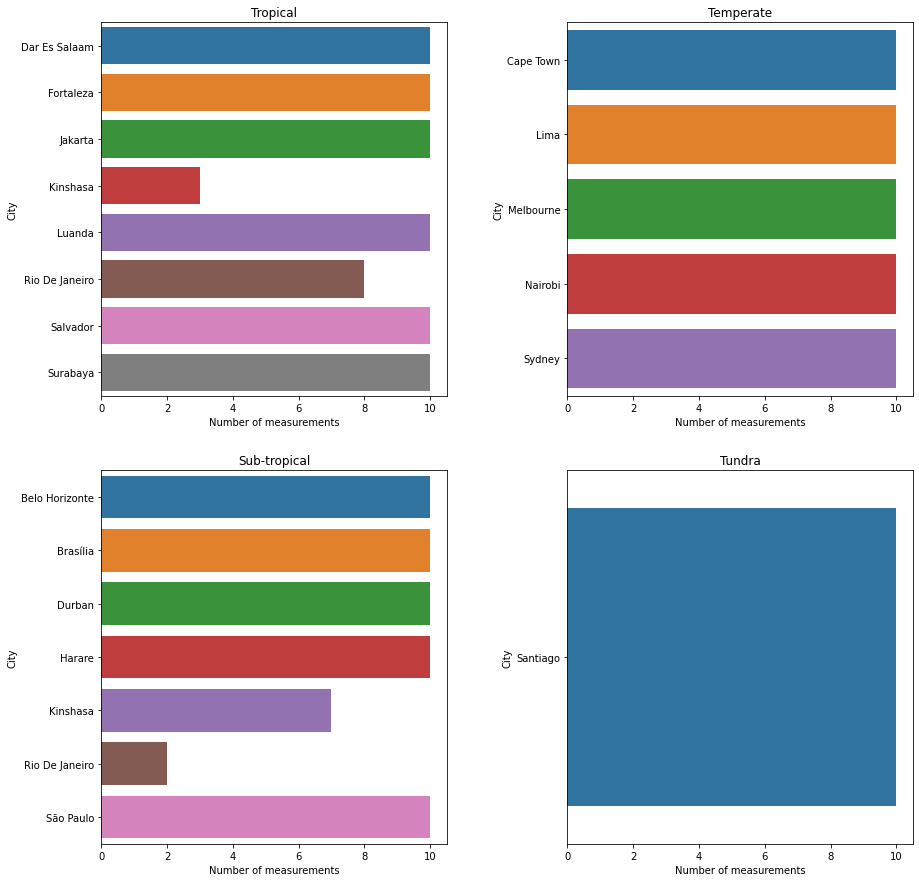

In [61]:
plt.figure(figsize=(7,7))
plot_city_counts(df_avgtempsaustral_ts, austral_labels, 'TimeSeriesKMeansLabelAvg', austral_labels)

As before, for the austral part we found that some cities have measurements belonging to different climate regions.

<Figure size 504x504 with 0 Axes>

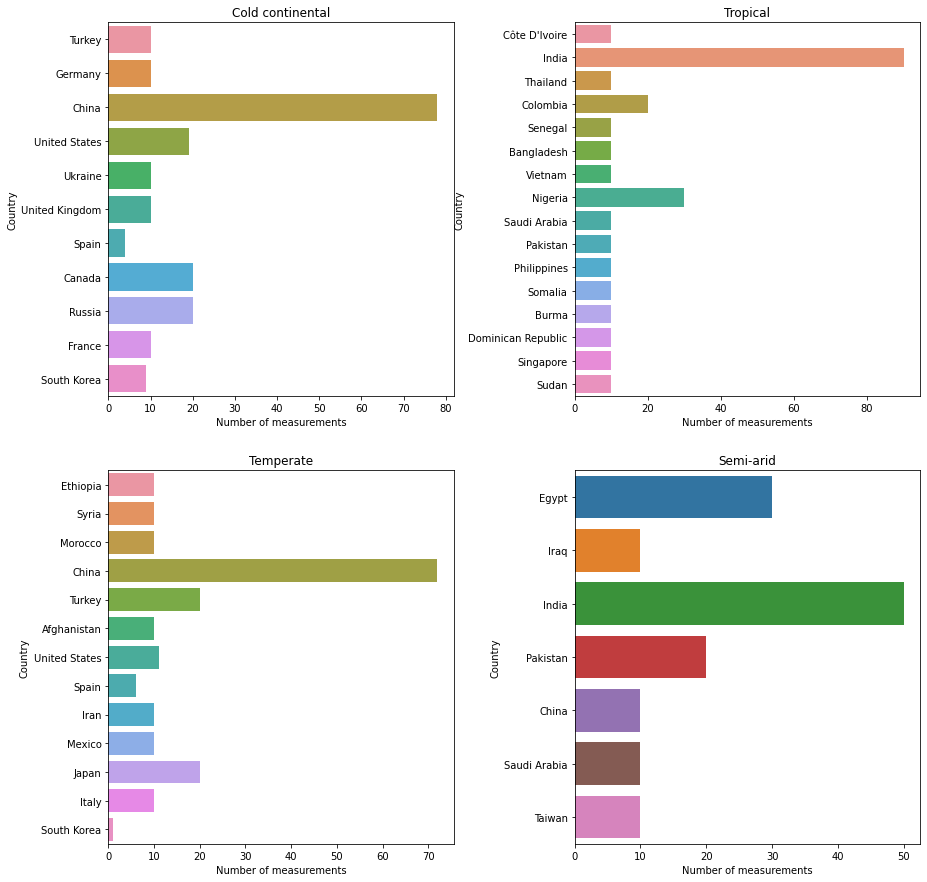

In [62]:
plt.figure(figsize=(7,7))
plot_country_counts(df_avgtempsboreal_ts, boreal_labels, 'TimeSeriesKMeansLabelAvg', boreal_labels)

In [63]:
df_austral_centroids = pd.DataFrame(centroids_avg_austral, columns=df_avgtempsaustral_ts.columns[5:-1])
df_austral_centroids['TimeSeriesKMeansLabelAvg'] = austral_labels
df_boreal_centroids = pd.DataFrame(centroids_avg_boreal, columns=df_avgtempsboreal_ts.columns[5:-1])
df_boreal_centroids['TimeSeriesKMeansLabelAvg'] = boreal_labels

df_austral_centroids

time,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
0,26.891462,26.886400,27.455937,26.585536,25.906509,25.465035,24.865137,25.684122,27.990331,27.624420,27.655485,26.093667,Tropical
1,19.696062,21.456319,19.517818,16.299178,13.815562,10.706675,10.386706,10.542387,13.148916,14.464239,17.325635,18.429560,Temperate
2,23.093291,24.420318,23.626715,22.851413,21.335537,20.487069,19.967591,20.626465,23.845792,22.787351,22.534820,22.991922,Sub-tropical
3,13.071878,12.350744,10.014074,5.987666,2.544625,0.919740,-0.473412,0.969503,2.422098,5.810922,10.156312,11.737998,Tundra


We now consider the 4 seasons by using boxplots to give us details about possible outliers in each different climate region.

### Spring<a name="spring"></a>

##### Austral Spring: lasts from 23th September to 21th December (90 days)

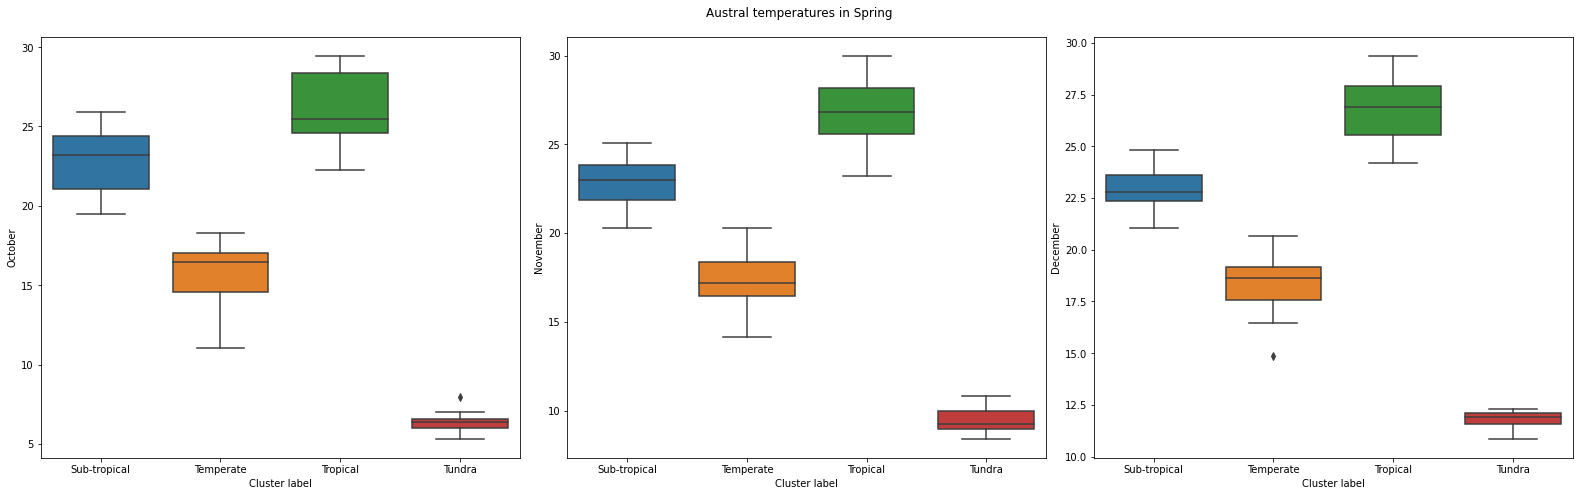

In [64]:
plot_box_hemisphere(df_avgtempsaustral_ts, 
                    [10, 11, 12],
                    'TimeSeriesKMeansLabelAvg', 
                    ['October', 'November', 'December'],
                    "Austral temperatures in Spring")

In [65]:
outliers = retrieve_outliers(df_avgtempsaustral_ts[(df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 'Tundra')], 10)
outliers

L: 5.111750000000002
U: 7.429749999999999


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
168,Santiago,Chile,32.95S,69.89W,2003.0,13.47,12.154,10.753,6.344,3.041,1.998,-0.75,0.688,4.106,7.969,10.448,11.066,Tundra


In [66]:
outliers = retrieve_outliers(df_avgtempsaustral_ts[(df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 'Temperate')], 12)
outliers

L: 15.106250000000006
U: 21.634249999999998


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
122,Melbourne,Australia,37.78S,144.41E,2001.0,21.809,22.045,17.305,14.092,11.307,10.367,9.265,9.866,12.715,12.365,14.165,14.859,Temperate


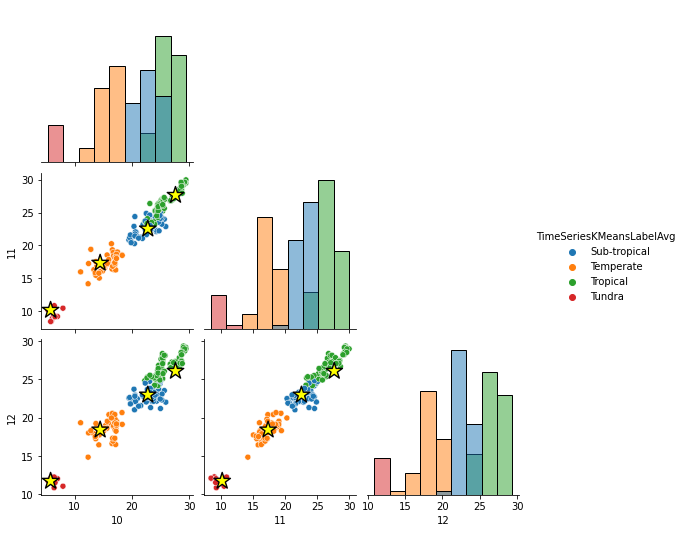

In [67]:
plot_scatters(df_avgtempsaustral_ts, [10, 11, 12], df_austral_centroids, 'TimeSeriesKMeansLabelAvg', [0, 1, 2, 3])

##### Boreal Spring: lasts from 21th March to 21th June (93 days)

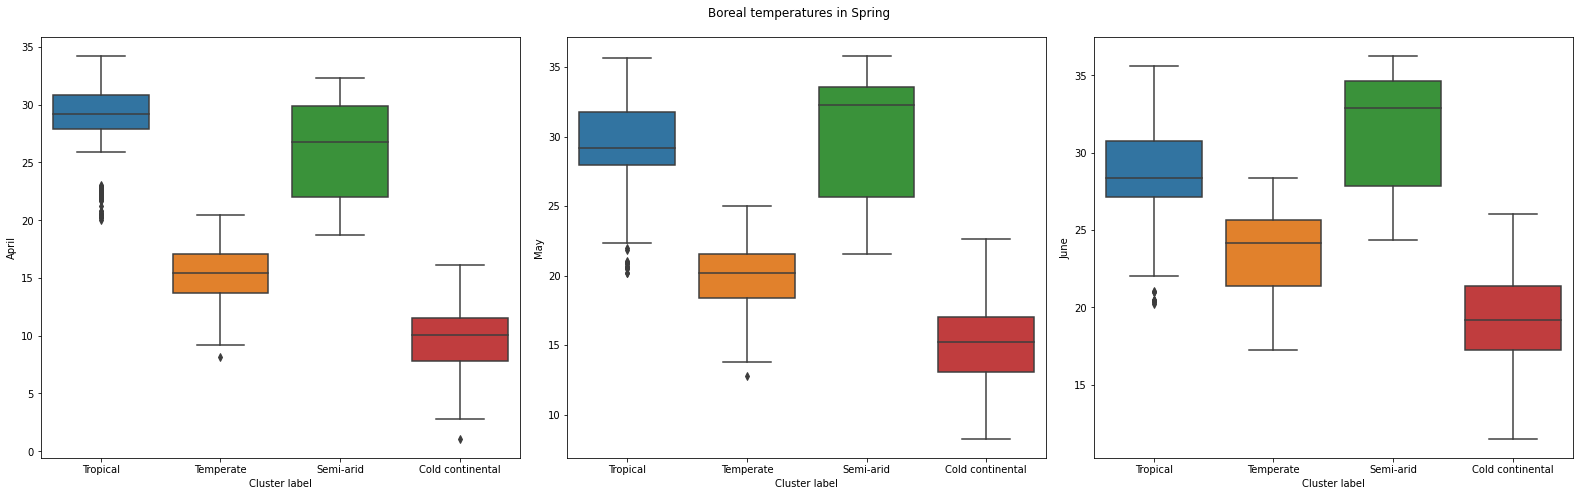

In [68]:
plot_box_hemisphere(df_avgtempsboreal_ts,  
                    [4, 5, 6], 
                    'TimeSeriesKMeansLabelAvg', 
                    ['April', 'May', 'June'], 
                    "Boreal temperatures in Spring")

In [69]:
outliers = retrieve_outliers(df_avgtempsboreal_ts[(df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 'Tropical')], 4)
outliers

L: 23.462750000000007
U: 35.262750000000004


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
110,Bogotá,Colombia,4.02N,74.73W,2000.0,20.7696,19.957,20.226,19.990,20.164,20.414,20.518,21.201,20.118,20.457,19.952,19.933,Tropical
111,Bogotá,Colombia,4.02N,74.73W,2001.0,20.1690,20.896,20.628,20.763,20.651,20.461,21.101,21.915,20.931,20.867,20.248,20.269,Tropical
112,Bogotá,Colombia,4.02N,74.73W,2002.0,20.8430,21.190,21.098,20.255,20.930,20.482,21.106,21.835,21.505,20.716,20.425,20.684,Tropical
113,Bogotá,Colombia,4.02N,74.73W,2003.0,21.4480,21.788,21.294,20.623,21.037,20.353,21.040,21.614,21.144,20.386,19.869,20.200,Tropical
114,Bogotá,Colombia,4.02N,74.73W,2004.0,20.5640,21.409,21.709,20.446,20.574,20.974,20.717,21.871,20.935,20.461,20.297,20.255,Tropical
115,Bogotá,Colombia,4.02N,74.73W,2005.0,20.7100,21.232,21.346,20.761,20.834,21.010,21.383,21.753,21.681,20.157,20.161,20.047,Tropical
116,Bogotá,Colombia,4.02N,74.73W,2006.0,20.3900,21.133,20.415,20.306,20.620,20.455,21.327,22.008,21.692,20.756,20.059,20.295,Tropical
117,Bogotá,Colombia,4.02N,74.73W,2007.0,21.3620,21.829,21.051,20.453,20.480,20.339,21.101,20.959,21.411,19.958,20.199,19.629,Tropical
118,Bogotá,Colombia,4.02N,74.73W,2008.0,20.2010,20.496,20.582,20.205,20.201,20.198,20.438,20.825,20.903,20.081,19.939,19.971,Tropical
119,Bogotá,Colombia,4.02N,74.73W,2009.0,20.0930,20.570,20.232,20.541,20.938,21.030,21.322,22.168,22.166,21.216,20.572,21.235,Tropical


We can see that the city of Dakar have more a sub-tropical climate because the mean temperatures change a lot between the various seasons. The cities of Cali and Bogotà have lower temperatures than the other tropical cities but they do not differentiate a lot between the seasons.

In [70]:
outliers = retrieve_outliers(df_avgtempsboreal_ts[(df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 'Cold continental')], 4)
outliers

L: 2.349000000000003
U: 16.988999999999997


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
718,Saint Petersburg,Russia,60.27N,29.19E,2003.0,-10.326,-6.324,-2.442,1.079,10.033,11.515,19.782,15.741,11.667,4.769,3.059,-0.384,Cold continental


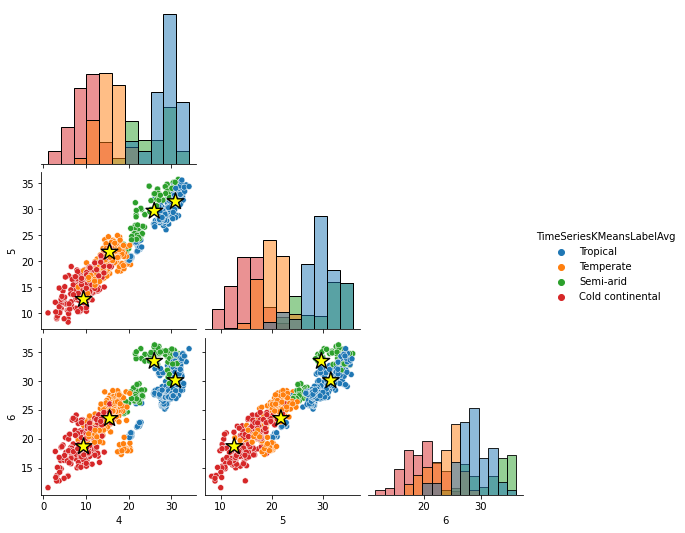

In [71]:
plot_scatters(df_avgtempsboreal_ts, [4, 5, 6], df_boreal_centroids, 'TimeSeriesKMeansLabelAvg', boreal_labels)

### Summer<a name="summer"></a>

##### Austral Summer: from 22nd December to 20th March (89 days)

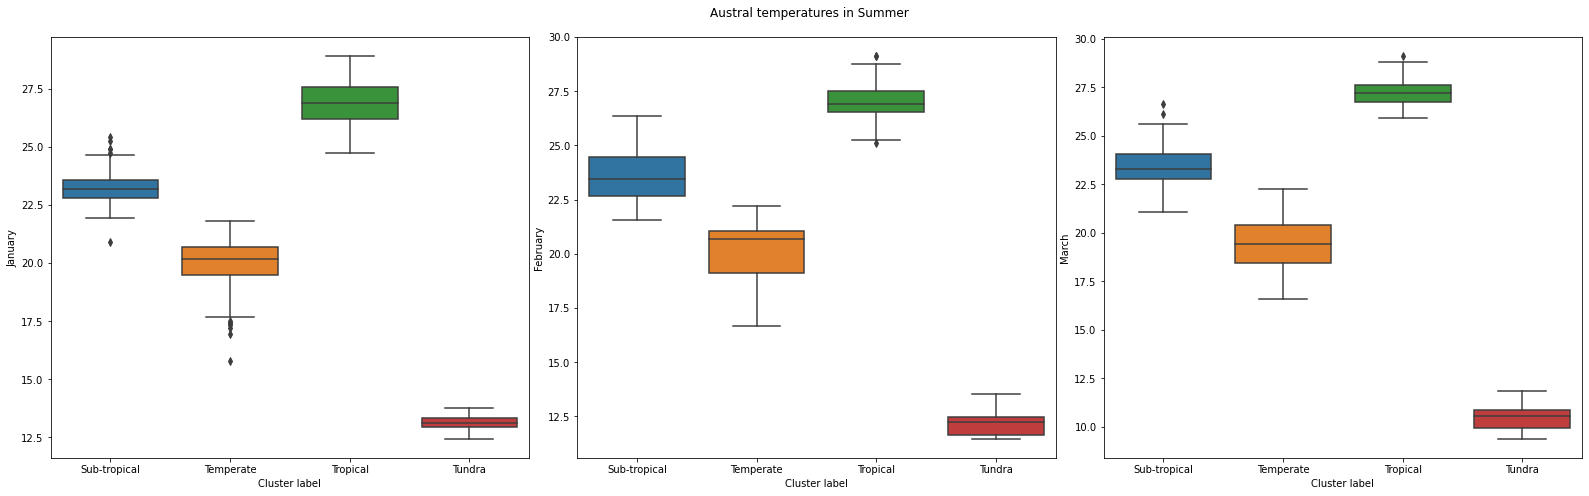

In [72]:
plot_box_hemisphere(df_avgtempsaustral_ts, 
                    [1, 2, 3], 
                    'TimeSeriesKMeansLabelAvg',
                    ['January', 'February', 'March'],
                    "Austral temperatures in Summer")

In [73]:
outliers = retrieve_outliers(df_avgtempsaustral_ts[(df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 'Sub-tropical')], 1)
outliers

L: 21.64175000000002
U: 24.723749999999985


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
74,Harare,Zimbabwe,18.48S,30.42E,2008.0,20.9050,21.752,21.355,19.509,18.942,16.876,16.529,18.616,22.150,24.963,24.119,22.450,Sub-tropical
88,Kinshasa,Congo (Democratic Republic Of The),4.02S,15.27E,2000.0,24.9074,24.513,25.480,25.302,25.113,23.126,22.107,22.598,24.109,24.361,24.630,24.256,Sub-tropical
90,Kinshasa,Congo (Democratic Republic Of The),4.02S,15.27E,2002.0,24.9070,25.659,25.411,25.794,26.028,23.695,22.941,23.382,24.521,24.496,24.515,24.169,Sub-tropical
94,Kinshasa,Congo (Democratic Republic Of The),4.02S,15.27E,2006.0,24.7310,25.537,25.603,25.574,24.832,24.448,23.057,23.354,24.208,24.705,24.574,24.423,Sub-tropical
147,Rio De Janeiro,Brazil,23.31S,42.82W,2004.0,25.4350,26.005,26.127,25.958,24.307,23.682,22.823,22.428,23.508,22.337,23.720,24.529,Sub-tropical
151,Rio De Janeiro,Brazil,23.31S,42.82W,2008.0,25.2570,26.362,26.631,25.793,24.031,23.713,23.361,23.855,22.045,23.207,23.028,23.841,Sub-tropical


In [74]:
outliers = retrieve_outliers(df_avgtempsaustral_ts[(df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 'Temperate')], 1)
outliers

L: 17.651875
U: 22.520875


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
125,Melbourne,Australia,37.78S,144.41E,2004.0,17.411,19.396,17.104,14.690,10.969,9.461,8.282,9.727,11.100,13.708,15.457,17.600,Temperate
132,Nairobi,Kenya,0.80S,36.16E,2000.0,17.403,17.780,18.413,17.840,17.190,15.851,15.206,15.602,16.174,16.747,16.557,16.824,Temperate
133,Nairobi,Kenya,0.80S,36.16E,2001.0,15.791,16.680,16.804,16.266,16.332,15.062,14.456,15.568,16.216,16.839,16.316,16.832,Temperate
134,Nairobi,Kenya,0.80S,36.16E,2002.0,17.204,18.380,17.735,17.154,16.673,15.779,15.593,15.075,16.182,16.537,16.414,16.640,Temperate
135,Nairobi,Kenya,0.80S,36.16E,2003.0,17.316,18.976,18.632,17.854,16.559,15.504,15.025,15.117,16.168,16.875,17.198,17.262,Temperate
139,Nairobi,Kenya,0.80S,36.16E,2007.0,16.940,17.826,18.039,17.289,16.937,15.623,14.738,15.046,16.234,16.708,16.860,16.953,Temperate
140,Nairobi,Kenya,0.80S,36.16E,2008.0,17.520,17.810,17.553,17.014,16.630,15.485,14.864,15.495,16.719,16.640,16.839,17.341,Temperate


In [75]:
outliers = retrieve_outliers(df_avgtempsaustral_ts[(df_avgtempsaustral_ts['TimeSeriesKMeansLabelAvg'] == 'Tropical')], 2)
outliers

L: 25.158000000000012
U: 28.885999999999992


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
38,Dar Es Salaam,Tanzania,7.23S,39.73E,2005.0,28.511,29.114,28.810,28.162,26.782,26.124,24.470,24.107,24.984,25.337,26.767,28.387,Tropical
39,Dar Es Salaam,Tanzania,7.23S,39.73E,2006.0,28.651,29.131,28.026,26.930,26.067,25.039,24.373,24.397,24.605,25.399,26.485,27.240,Tropical
92,Kinshasa,Congo (Democratic Republic Of The),4.02S,15.27E,2004.0,25.131,25.098,25.899,25.404,24.966,22.625,22.514,24.055,24.527,25.394,25.245,25.114,Tropical


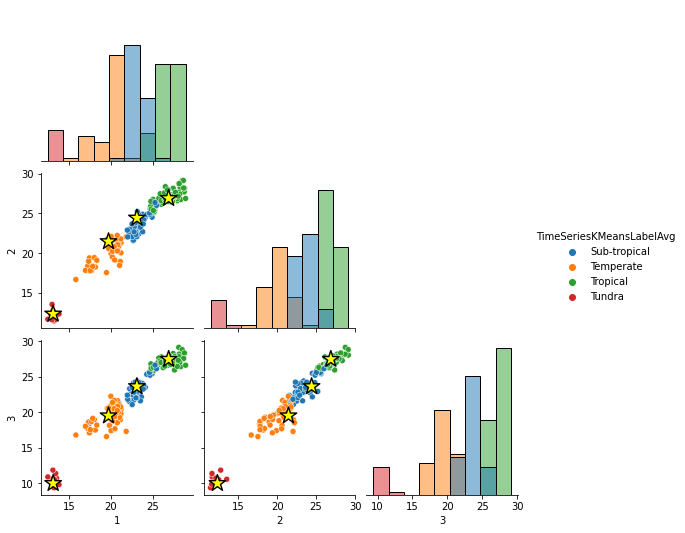

In [76]:
plot_scatters(df_avgtempsaustral_ts, [1, 2, 3], df_austral_centroids, 'TimeSeriesKMeansLabelAvg', [0, 1, 2, 3])

##### Boreal Summer: from 22nd June to 22nd September (93 days)

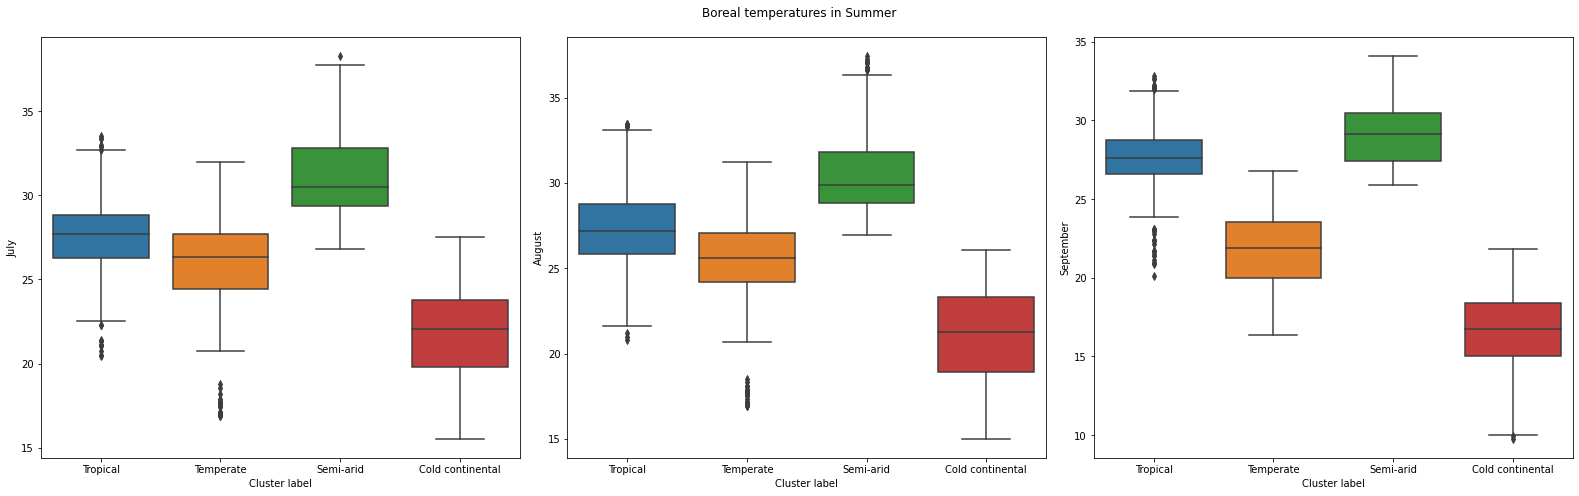

In [77]:
plot_box_hemisphere(df_avgtempsboreal_ts, 
                    [7, 8, 9], 
                    'TimeSeriesKMeansLabelAvg',
                    ['July', 'August', 'September'],
                    "Boreal temperatures in Summer")

In [78]:
outliers = retrieve_outliers(df_avgtempsboreal_ts[(df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 'Temperate')], 8)
outliers

L: 19.89112499999999
U: 31.418125000000007


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
11,Addis Abeba,Ethiopia,8.84N,38.11E,2000.0,18.2615,19.183,20.230,20.398,19.977,18.254,17.109,16.944,17.542,17.113,17.741,17.013,Temperate
12,Addis Abeba,Ethiopia,8.84N,38.11E,2001.0,17.4540,18.864,20.043,20.233,19.908,17.978,17.011,17.152,17.867,18.047,17.306,17.694,Temperate
13,Addis Abeba,Ethiopia,8.84N,38.11E,2002.0,17.9010,19.471,20.193,20.097,20.234,18.084,17.518,17.171,17.405,17.324,17.964,18.275,Temperate
14,Addis Abeba,Ethiopia,8.84N,38.11E,2003.0,18.2010,19.210,20.453,20.270,20.409,18.428,16.861,17.150,17.298,17.137,17.431,17.003,Temperate
15,Addis Abeba,Ethiopia,8.84N,38.11E,2004.0,18.9830,18.986,19.813,19.634,20.015,18.148,17.109,17.317,17.468,16.956,17.235,17.849,Temperate
16,Addis Abeba,Ethiopia,8.84N,38.11E,2005.0,17.9400,19.785,20.685,20.464,19.366,17.923,16.991,17.563,17.797,17.419,16.955,16.866,Temperate
17,Addis Abeba,Ethiopia,8.84N,38.11E,2006.0,18.5260,20.512,20.482,19.595,19.648,18.222,16.926,16.963,17.374,17.799,17.793,17.285,Temperate
18,Addis Abeba,Ethiopia,8.84N,38.11E,2007.0,18.4840,18.959,20.045,19.619,19.805,17.998,17.002,16.905,17.192,17.108,17.502,17.092,Temperate
19,Addis Abeba,Ethiopia,8.84N,38.11E,2008.0,18.7730,19.493,19.735,19.704,19.459,17.899,16.853,16.960,17.736,17.460,16.950,16.958,Temperate
20,Addis Abeba,Ethiopia,8.84N,38.11E,2009.0,17.9630,19.824,20.189,20.335,20.283,19.222,17.484,17.513,18.187,17.788,18.098,18.298,Temperate


We can see that the cities of Addis Abeba and Mexico have low temperatures in July and especially in August, this is maybe due to a lot of precipitations. 

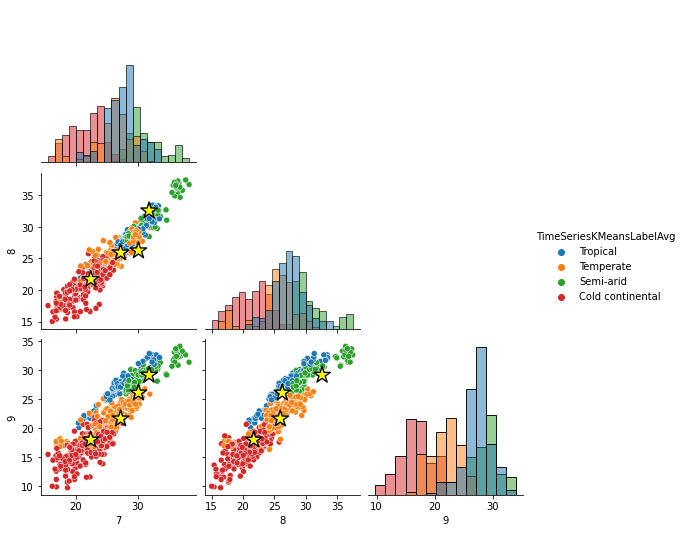

In [79]:
plot_scatters(df_avgtempsboreal_ts, [7, 8, 9], df_boreal_centroids, 'TimeSeriesKMeansLabelAvg', [0, 1, 2, 3])

### Autumn<a name="autumn"></a>

##### Austral Autumn: from 21st March to 21th June (93 days)

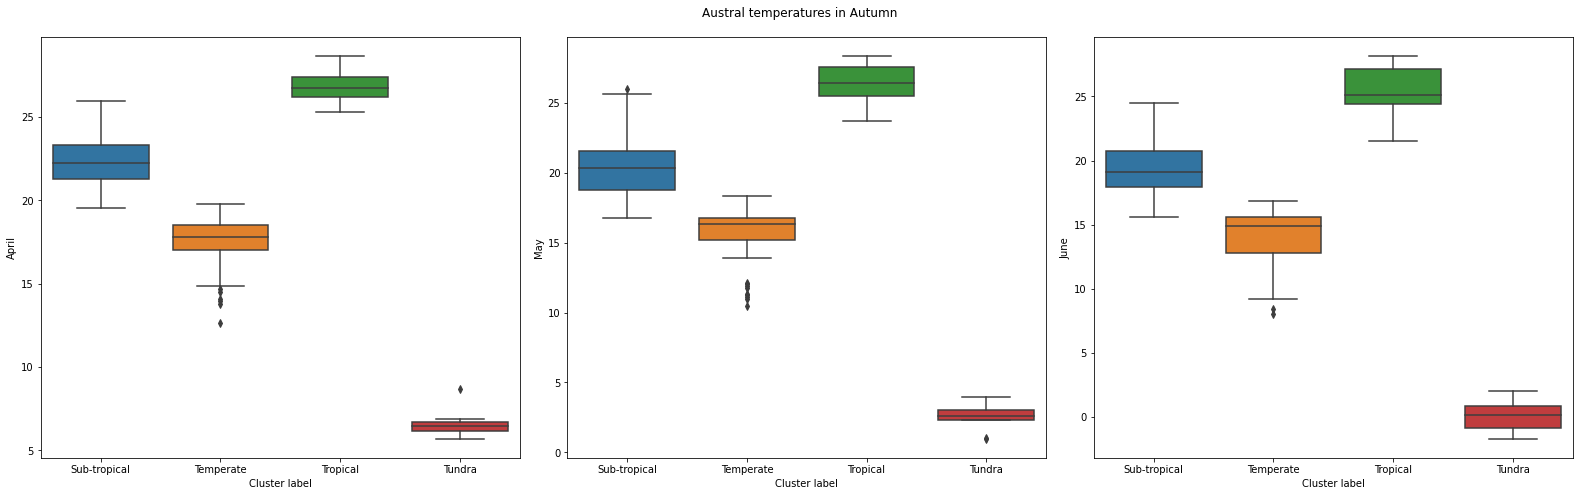

In [80]:
plot_box_hemisphere(df_avgtempsaustral_ts, 
                    [4, 5, 6], 
                    'TimeSeriesKMeansLabelAvg',
                    ['April', 'May', 'June'],
                    "Austral temperatures in Autumn")

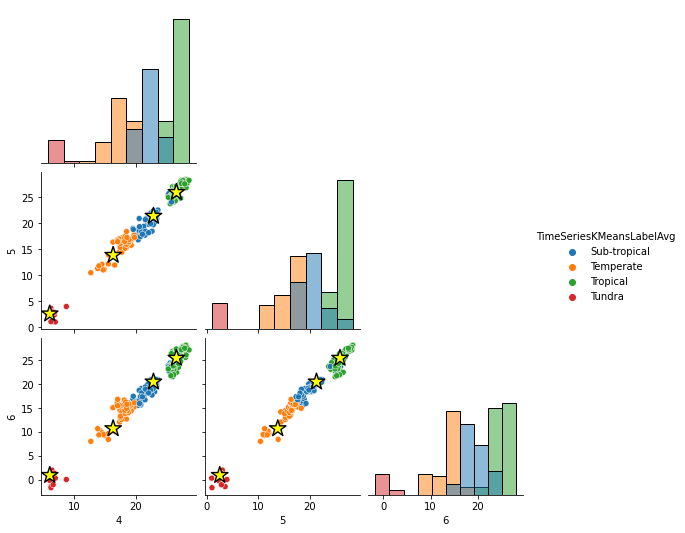

In [81]:
plot_scatters(df_avgtempsaustral_ts, [4, 5, 6], df_austral_centroids, 'TimeSeriesKMeansLabelAvg', [0, 1, 2, 3])

##### Boreal Autumn: from 23rd September to 21st December (90 days)

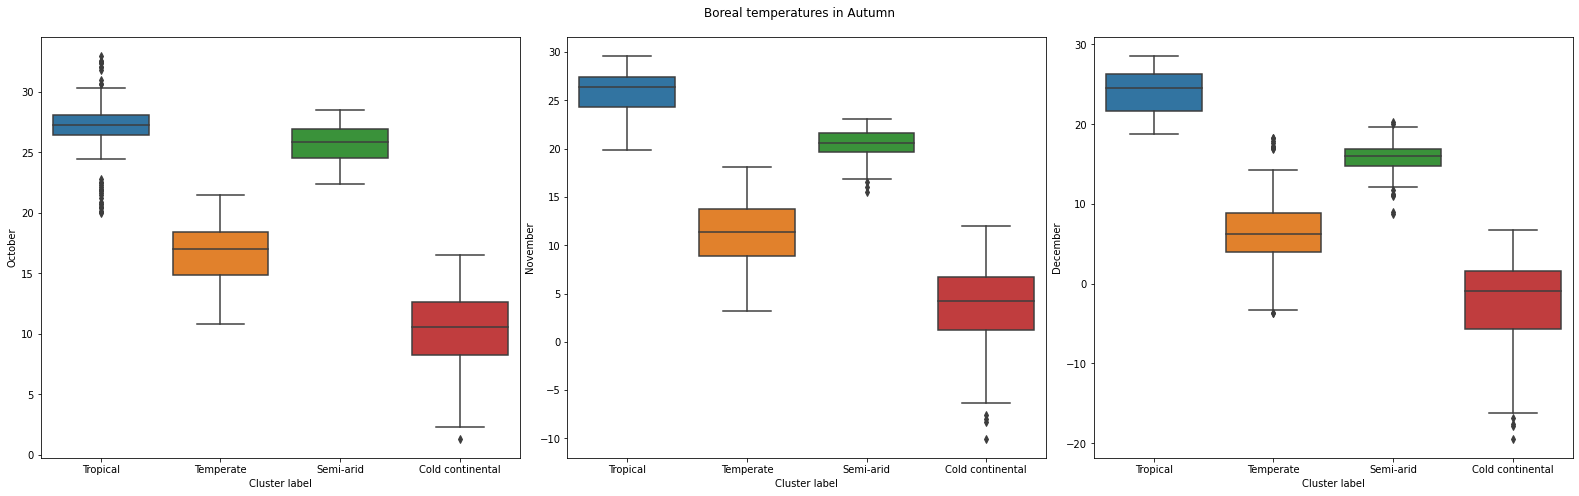

In [82]:
plot_box_hemisphere(df_avgtempsboreal_ts, 
                    [10, 11, 12], 
                    'TimeSeriesKMeansLabelAvg',
                    ['October', 'November', 'December'],
                    "Boreal temperatures in Autumn")

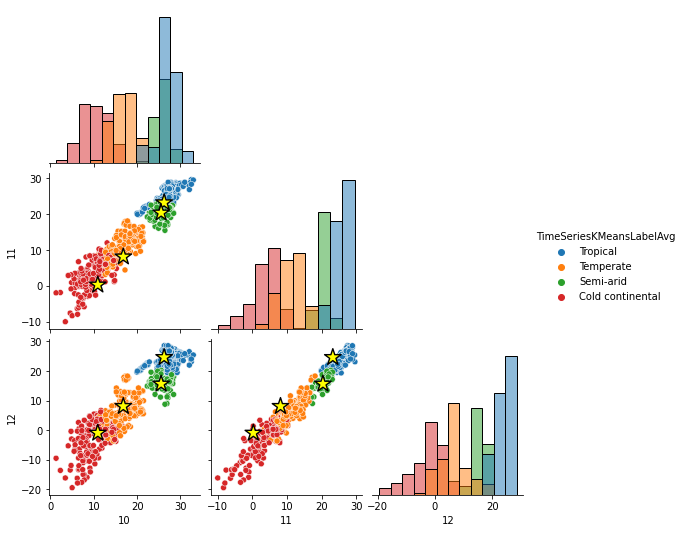

In [83]:
plot_scatters(df_avgtempsboreal_ts, [10, 11, 12], df_boreal_centroids, 'TimeSeriesKMeansLabelAvg', [0, 1, 2, 3])

### Winter<a name="winter"></a>

##### Austral Winter: from 22st June to 22th September (93 days)

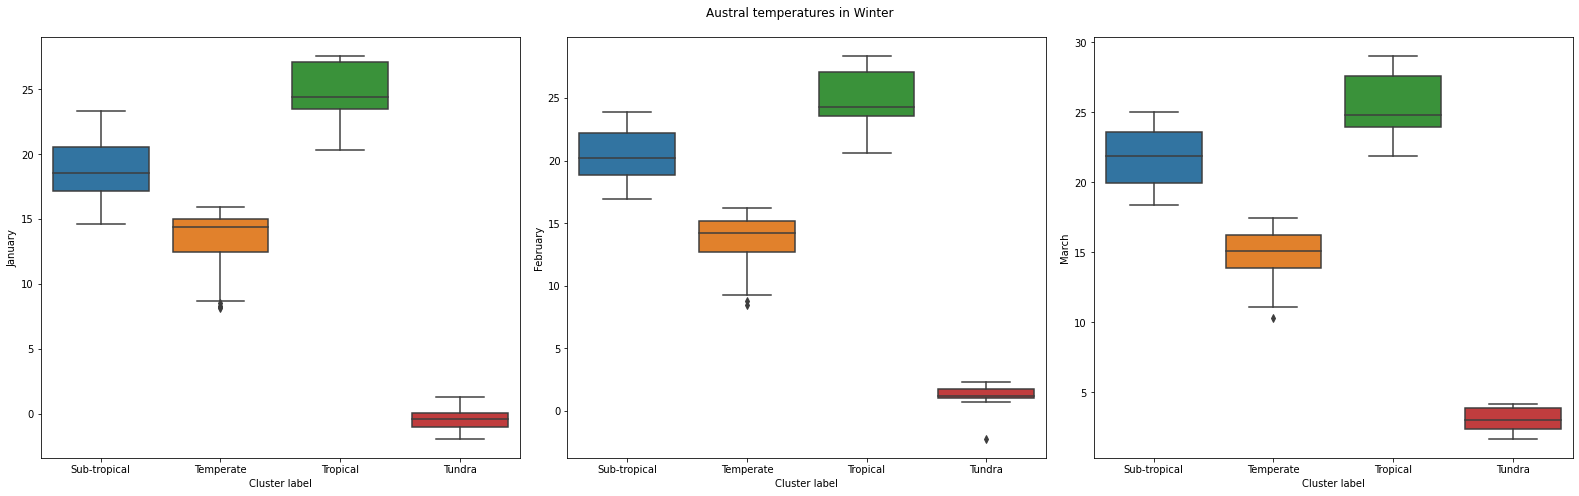

In [84]:
plot_box_hemisphere(df_avgtempsaustral_ts, 
                    [7, 8, 9],
                    'TimeSeriesKMeansLabelAvg',  
                    ['January', 'February', 'March'],
                    "Austral temperatures in Winter")

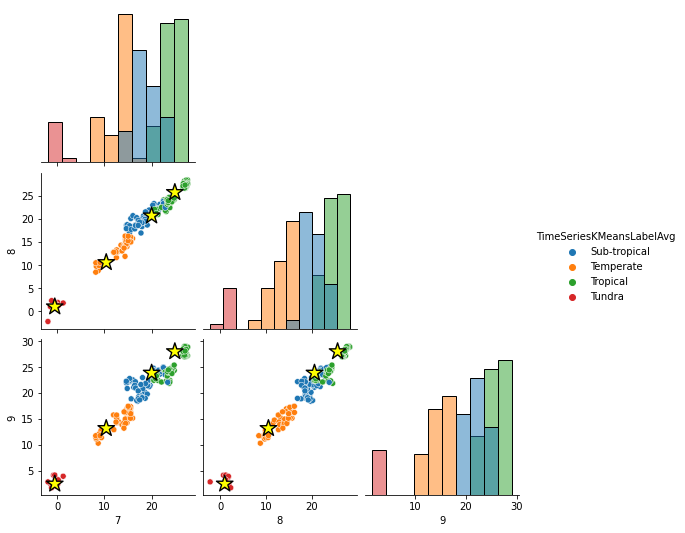

In [85]:
plot_scatters(df_avgtempsaustral_ts, [7, 8, 9], df_austral_centroids, 'TimeSeriesKMeansLabelAvg', [0, 1, 2, 3])

##### Boreal Winter: from 22nd December to 20th March (89 days)

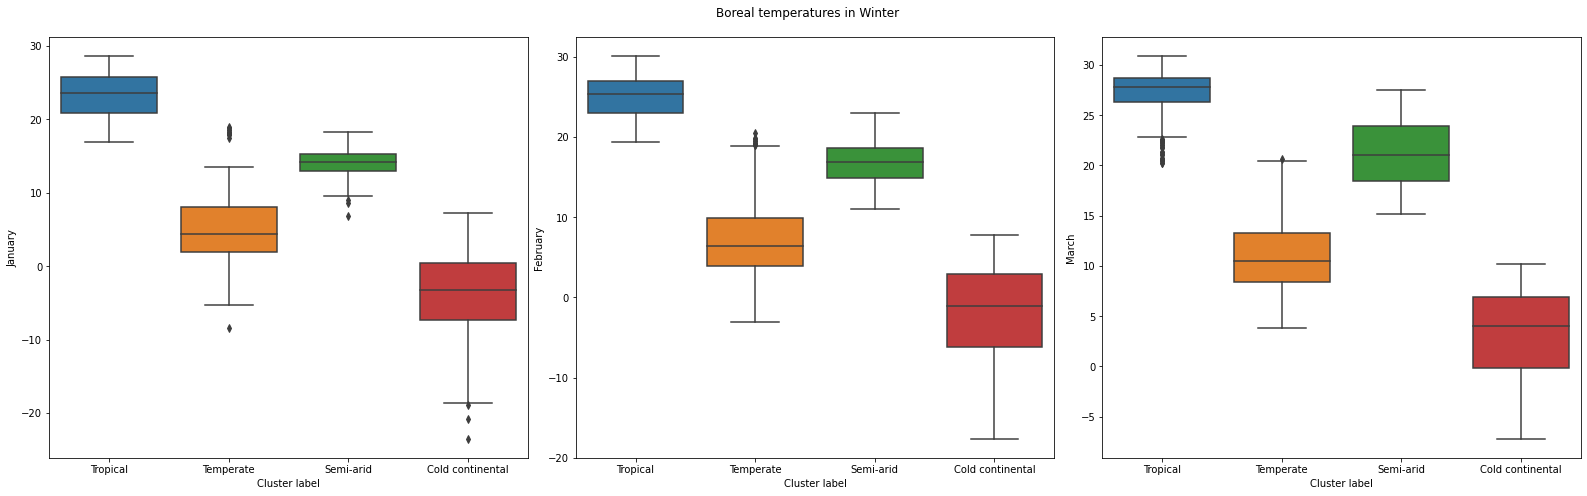

In [86]:
plot_box_hemisphere(df_avgtempsboreal_ts, 
                    [1, 2, 3], 
                    'TimeSeriesKMeansLabelAvg',
                    ['January', 'February', 'March'],
                    "Boreal temperatures in Winter")

In [87]:
outliers = retrieve_outliers(df_avgtempsboreal_ts[(df_avgtempsboreal_ts['TimeSeriesKMeansLabelAvg'] == 'Cold continental')], 1)
outliers

L: -18.800874999999994
U: 11.956124999999997


time,City,Country,Latitude,Longitude,Year,1,2,3,4,5,6,7,8,9,10,11,12,TimeSeriesKMeansLabelAvg
177,Changchun,China,44.20N,125.22E,2001.0,-20.871,-14.362,-3.046,9.273,17.066,22.992,24.645,22.306,16.666,9.122,-1.848,-12.802,Cold continental
298,Harbin,China,45.81N,125.77E,2001.0,-23.495,-17.095,-4.454,8.185,16.334,22.632,24.588,22.103,15.538,7.555,-3.395,-14.965,Cold continental
303,Harbin,China,45.81N,125.77E,2006.0,-18.862,-13.607,-3.316,5.170,16.946,20.207,23.269,22.750,15.862,6.673,-5.379,-13.131,Cold continental


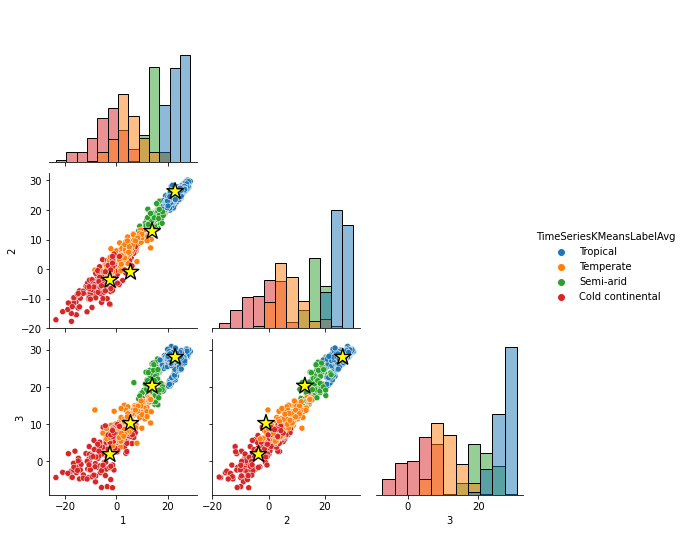

In [88]:
plot_scatters(df_avgtempsboreal_ts, [1, 2, 3], df_boreal_centroids, 'TimeSeriesKMeansLabelAvg', [0, 1, 2, 3])

## Cluster on AverageTemperatureUncertainty<a name="avg-temp-uncertainty"></a>

We compute SSE and silhouette for the euclidean and DTW metric for k in \[2, 7]

In [89]:
scores_austral = compute_scores(to_time_series_dataset(stdaustral_values_norm))
scores_boreal = compute_scores(to_time_series_dataset(stdboreal_values_norm))

df_stdtemps_ts_boreal_results = pd.DataFrame(scores_boreal, columns = ['K', 'EuclideanSSE', 'DTWSSE', 'EuclideanSilhouette', 'DTWSilhouette'])
df_stdtemps_ts_boreal_results.set_index(['K'], inplace=True)

df_stdtemps_ts_austral_results = pd.DataFrame(scores_austral, columns = ['K', 'EuclideanSSE', 'DTWSSE', 'EuclideanSilhouette', 'DTWSilhouette'])
df_stdtemps_ts_austral_results.set_index(['K'], inplace=True)

In [90]:
df_stdtemps_ts_austral_results

,EuclideanSSE,DTWSSE,EuclideanSilhouette,DTWSilhouette
K,,,,
2,0.165614,0.094937,0.542769,0.587600
3,0.141551,0.079882,0.203782,0.239964
4,0.131059,0.072128,0.193163,0.221430
5,0.120748,0.066413,0.149568,0.205351
6,0.115015,0.064054,0.137213,0.190407
7,0.109787,0.058239,0.137215,0.166050


In [91]:
df_stdtemps_ts_boreal_results

,EuclideanSSE,DTWSSE,EuclideanSilhouette,DTWSilhouette
K,,,,
2,0.113165,0.071311,0.381929,0.480196
3,0.100219,0.061494,0.223562,0.287918
4,0.094749,0.056069,0.226083,0.252310
5,0.090143,0.052012,0.163789,0.228620
6,0.085916,0.049847,0.156111,0.190093
7,0.083934,0.046981,0.124278,0.175376


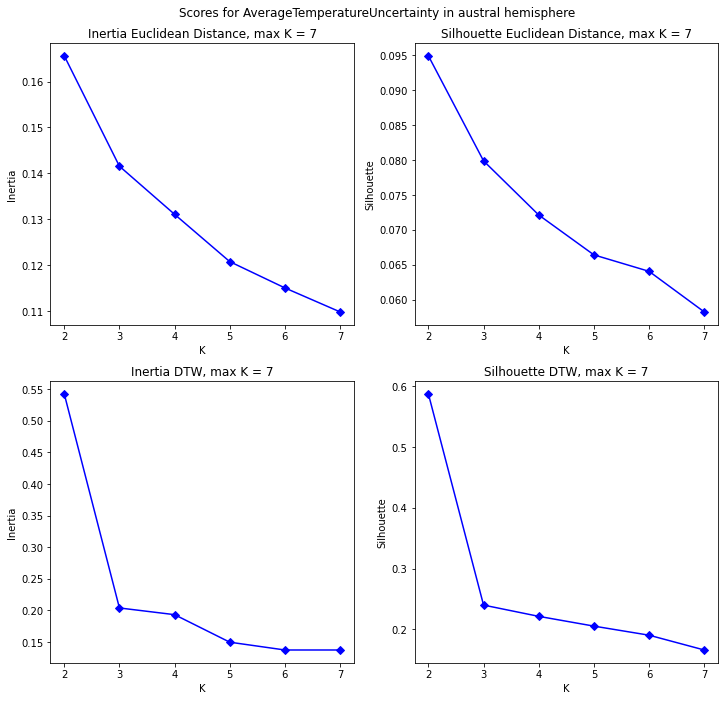

In [92]:
plot_scores(df_stdtemps_ts_austral_results, "Scores for AverageTemperatureUncertainty in austral hemisphere")

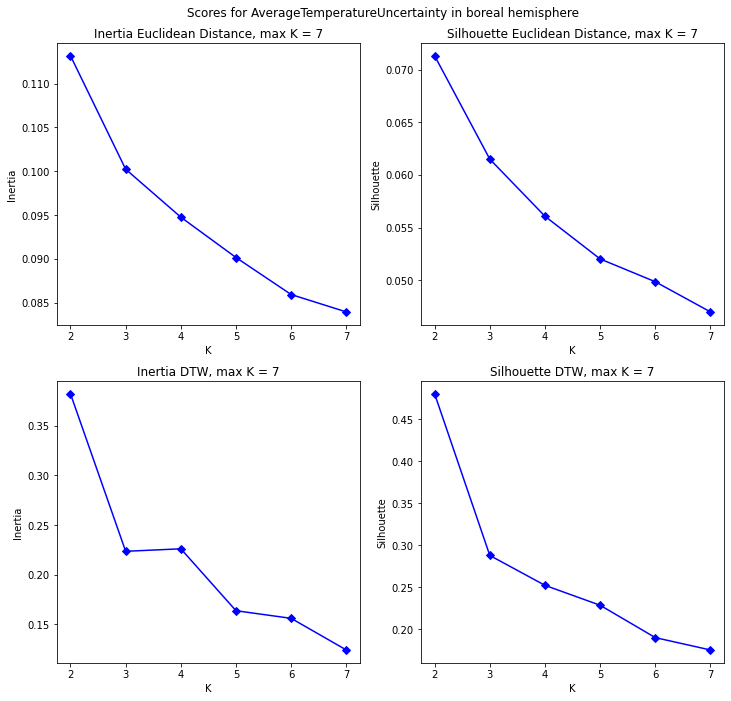

In [93]:
plot_scores(df_stdtemps_ts_boreal_results, "Scores for AverageTemperatureUncertainty in boreal hemisphere")

We choose `k = 2` for both the hemisphere because we want to spot the regions where there are better defined seasons (hot dry summers and cold wet winters) and the rest.

In [94]:
tskm_std_boreal = TimeSeriesKMeans(n_clusters=2, metric='dtw', max_iter=20, random_state=69)
tskm_std_boreal.fit(to_time_series_dataset(stdboreal_values_norm))

TimeSeriesKMeans(max_iter=20, metric='dtw', n_clusters=2, random_state=69)

In [95]:
tskm_std_austral = TimeSeriesKMeans(n_clusters=2, metric='dtw', max_iter=20, random_state=69)
tskm_std_austral.fit(to_time_series_dataset(stdaustral_values_norm))

TimeSeriesKMeans(max_iter=20, metric='dtw', n_clusters=2, random_state=69)

In [96]:
boreal_centroids = minmax_scaler_stdboreal.inverse_transform(tskm_std_boreal.cluster_centers_.reshape((2, 12)))

print(boreal_centroids)

[[0.37389776 0.24176531 0.25535568 0.26263215 0.2513657  0.40973327
  0.24722954 0.25698858 0.20214076 0.44575068 0.20222002 0.3375693 ]
 [0.52887157 1.12446345 0.38446824 0.68810448 0.33671422 0.34270984
  0.42466329 0.34437288 0.54636213 0.48262904 0.45221162 0.5599949 ]]


In [97]:
austral_centroids = minmax_scaler_stdaustral.inverse_transform(tskm_std_austral.cluster_centers_.reshape((2, 12)))

print(austral_centroids)

[[0.3436645  0.36622585 0.43270482 0.32413422 0.27225254 0.3443935
  0.26583296 0.34760356 0.30675448 0.38708196 0.26588715 0.35301829]
 [0.91673614 0.59893411 0.87576214 0.46478277 0.6712074  0.73899935
  0.79616004 0.49748914 0.76233146 1.16030953 0.78781113 0.51580128]]


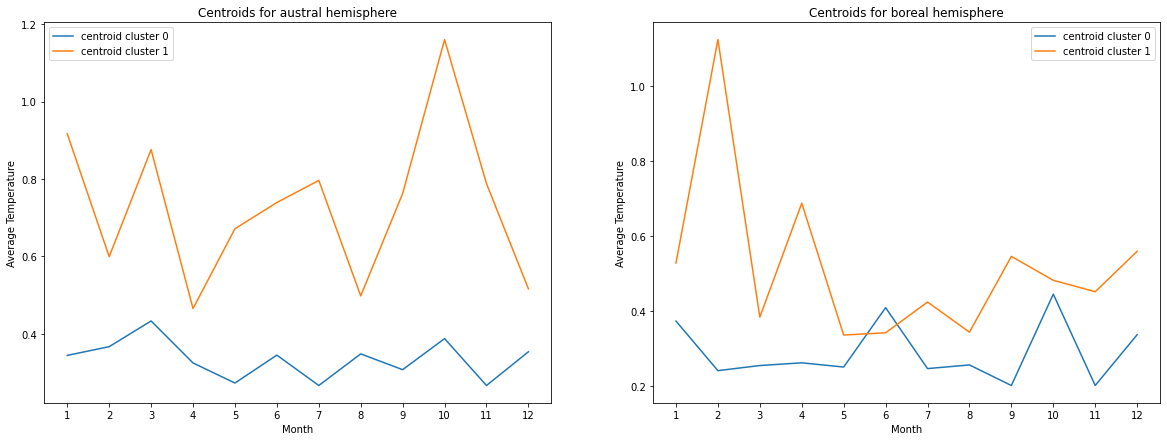

In [98]:
plot_centroids(austral_centroids, 
               boreal_centroids, 
               ['centroid cluster 0', 'centroid cluster 1'],
               ['centroid cluster 0', 'centroid cluster 1'])

In [99]:
df_stdtempsboreal_ts['TimeSeriesKMeansLabelStd'] = tskm_std_boreal.predict(to_time_series_dataset(stdboreal_values_norm))
df_stdtempsaustral_ts['TimeSeriesKMeansLabelStd'] = tskm_std_austral.predict(to_time_series_dataset(stdaustral_values_norm))

In [100]:
df_stdtempsboreal_ts[df_stdtempsboreal_ts['TimeSeriesKMeansLabelStd'] == 0]['City'].unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Berlin', 'Bogotá',
       'Bombay', 'Cairo', 'Calcutta', 'Cali', 'Casablanca', 'Changchun',
       'Chengdu', 'Chicago', 'Chongqing', 'Dalian', 'Delhi', 'Dhaka',
       'Faisalabad', 'Gizeh', 'Guangzhou', 'Harbin', 'Ho Chi Minh City',
       'Hyderabad', 'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jiddah',
       'Jinan', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Lagos', 'Lahore',
       'Lakhnau', 'London', 'Los Angeles', 'Madras', 'Madrid', 'Manila',
       'Mashhad', 'Mexico', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking', 'Pune',
       'Rangoon', 'Riyadh', 'Rome', 'Saint Petersburg', 'Santo Domingo',
       'Seoul', 'Shanghai', 'Shenyang', 'Singapore', 'Surat', 'Taipei',
       'Taiyuan', 'Tangshan', 'Tianjin', 'Tokyo', 'Toronto', 'Umm Durman',
       'Wuhan', 'Xian'], dtype=object)

These are mostly city with tropical climate even though there are some cities where there were measurements with low standard deviation like Rome (mediterranean) and Xian (continental)

In [101]:
df_stdtempsboreal_ts[df_stdtempsboreal_ts['TimeSeriesKMeansLabelStd'] == 1]['City'].unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Ankara', 'Baghdad',
       'Bombay', 'Casablanca', 'Chengdu', 'Chicago', 'Dakar', 'Delhi',
       'Dhaka', 'Faisalabad', 'Ibadan', 'Jaipur', 'Jiddah', 'Kabul',
       'Kano', 'Kanpur', 'Karachi', 'Lagos', 'Lahore', 'Lakhnau',
       'Los Angeles', 'Mashhad', 'Mexico', 'Mogadishu', 'New Delhi',
       'Rangoon', 'Riyadh', 'Rome', 'Surat', 'Umm Durman', 'Xian'],
      dtype=object)

As we can see we can distinguish in both the hemisphere two clusters:
- Cities where where between the seasons there isn't a sudden change of temperatures, mostly tropical and sub-tropical. We include these cities in a cluster with label `Low defined seasons`.
- Cities where there is an huge change between summer/winter and where in spring/autumn there is a moderate rise/decline of temperatures. We include these cities in a cluster with label `High defined seasons`.

In [102]:
boreal_std_labels = ['Low defined seasons', 'High defined seasons']
austral_std_labels = ['Low defined seasons', 'High defined seasons']

In [103]:
df_stdtempsboreal_ts.loc[df_stdtempsboreal_ts['TimeSeriesKMeansLabelStd'] == 0, 'TimeSeriesKMeansLabelStd'] = boreal_std_labels[0]
df_stdtempsboreal_ts.loc[df_stdtempsboreal_ts['TimeSeriesKMeansLabelStd'] == 1, 'TimeSeriesKMeansLabelStd'] = boreal_std_labels[1]

df_stdtempsaustral_ts.loc[df_stdtempsaustral_ts['TimeSeriesKMeansLabelStd'] == 0, 'TimeSeriesKMeansLabelStd'] = austral_std_labels[0]
df_stdtempsaustral_ts.loc[df_stdtempsaustral_ts['TimeSeriesKMeansLabelStd'] == 1, 'TimeSeriesKMeansLabelStd'] = austral_std_labels[1]

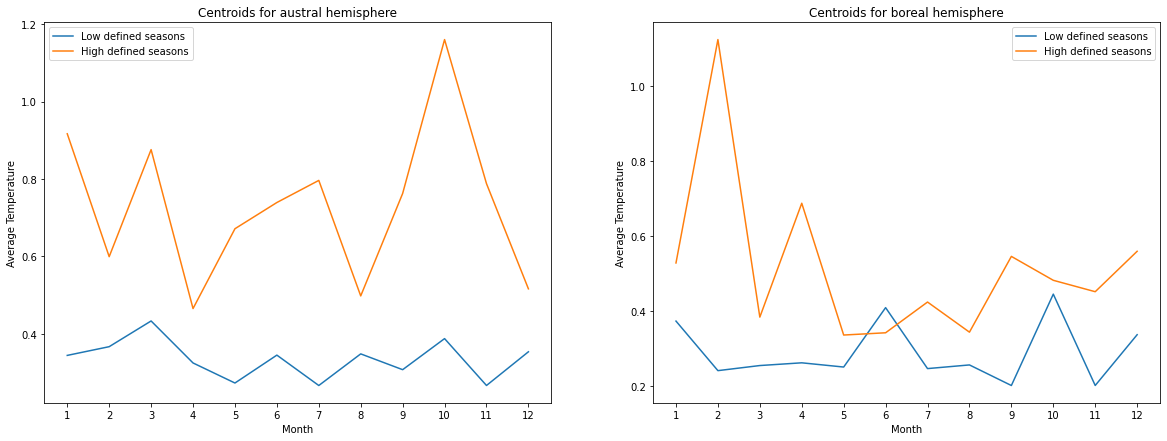

In [104]:
plot_centroids(austral_centroids, 
               boreal_centroids, 
               austral_std_labels,
               boreal_std_labels)

[Text(0.5, 24.0, 'Cluster label'),
 Text(643.5431818181817, 0.5, 'Number of measurements'),
 Text(0.5, 1.0, 'Austral hemisphere')]

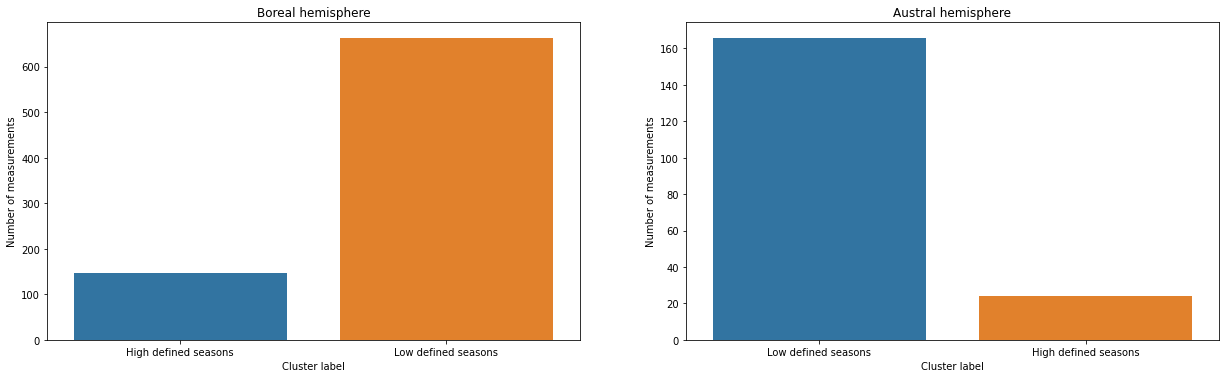

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

fig.tight_layout()
fig.subplots_adjust(wspace=0.2)

p = sns.countplot(x='TimeSeriesKMeansLabelStd', data=df_stdtempsboreal_ts, ax=axes[0])
p.set(xlabel='Cluster label', ylabel='Number of measurements', title='Boreal hemisphere')
p= sns.countplot(x='TimeSeriesKMeansLabelStd', data=df_stdtempsaustral_ts, ax=axes[1])
p.set(xlabel='Cluster label', ylabel='Number of measurements', title='Austral hemisphere')

### Boreal hemisphere<a name="boreal-regions-std"></a>

[Text(0, 0, 'Abidjan'),
 Text(1, 0, 'Addis Abeba'),
 Text(2, 0, 'Ahmadabad'),
 Text(3, 0, 'Aleppo'),
 Text(4, 0, 'Alexandria'),
 Text(5, 0, 'Ankara'),
 Text(6, 0, 'Baghdad'),
 Text(7, 0, 'Bangalore'),
 Text(8, 0, 'Bangkok'),
 Text(9, 0, 'Berlin'),
 Text(10, 0, 'Bogotá'),
 Text(11, 0, 'Bombay'),
 Text(12, 0, 'Cairo'),
 Text(13, 0, 'Calcutta'),
 Text(14, 0, 'Cali'),
 Text(15, 0, 'Casablanca'),
 Text(16, 0, 'Changchun'),
 Text(17, 0, 'Chengdu'),
 Text(18, 0, 'Chicago'),
 Text(19, 0, 'Chongqing'),
 Text(20, 0, 'Dalian'),
 Text(21, 0, 'Delhi'),
 Text(22, 0, 'Dhaka'),
 Text(23, 0, 'Faisalabad'),
 Text(24, 0, 'Gizeh'),
 Text(25, 0, 'Guangzhou'),
 Text(26, 0, 'Harbin'),
 Text(27, 0, 'Ho Chi Minh City'),
 Text(28, 0, 'Hyderabad'),
 Text(29, 0, 'Ibadan'),
 Text(30, 0, 'Istanbul'),
 Text(31, 0, 'Izmir'),
 Text(32, 0, 'Jaipur'),
 Text(33, 0, 'Jiddah'),
 Text(34, 0, 'Jinan'),
 Text(35, 0, 'Kano'),
 Text(36, 0, 'Kanpur'),
 Text(37, 0, 'Karachi'),
 Text(38, 0, 'Kiev'),
 Text(39, 0, 'Lagos'),
 Text(40

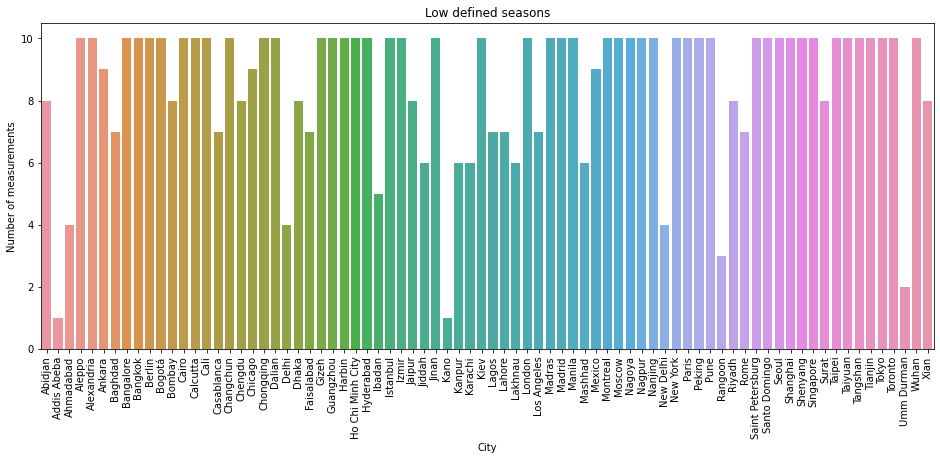

In [106]:
plt.figure(figsize=(16,6))

p = sns.countplot(x="City", data=df_stdtempsboreal_ts[df_stdtempsboreal_ts['TimeSeriesKMeansLabelStd'] == boreal_std_labels[0]])
p.set(ylabel='Number of measurements', title=boreal_std_labels[0])
p.set_xticklabels(p.get_xticklabels(), rotation = 90)

[Text(0, 0, 'Abidjan'),
 Text(1, 0, 'Addis Abeba'),
 Text(2, 0, 'Ahmadabad'),
 Text(3, 0, 'Ankara'),
 Text(4, 0, 'Baghdad'),
 Text(5, 0, 'Bombay'),
 Text(6, 0, 'Casablanca'),
 Text(7, 0, 'Chengdu'),
 Text(8, 0, 'Chicago'),
 Text(9, 0, 'Dakar'),
 Text(10, 0, 'Delhi'),
 Text(11, 0, 'Dhaka'),
 Text(12, 0, 'Faisalabad'),
 Text(13, 0, 'Ibadan'),
 Text(14, 0, 'Jaipur'),
 Text(15, 0, 'Jiddah'),
 Text(16, 0, 'Kabul'),
 Text(17, 0, 'Kano'),
 Text(18, 0, 'Kanpur'),
 Text(19, 0, 'Karachi'),
 Text(20, 0, 'Lagos'),
 Text(21, 0, 'Lahore'),
 Text(22, 0, 'Lakhnau'),
 Text(23, 0, 'Los Angeles'),
 Text(24, 0, 'Mashhad'),
 Text(25, 0, 'Mexico'),
 Text(26, 0, 'Mogadishu'),
 Text(27, 0, 'New Delhi'),
 Text(28, 0, 'Rangoon'),
 Text(29, 0, 'Riyadh'),
 Text(30, 0, 'Rome'),
 Text(31, 0, 'Surat'),
 Text(32, 0, 'Umm Durman'),
 Text(33, 0, 'Xian')]

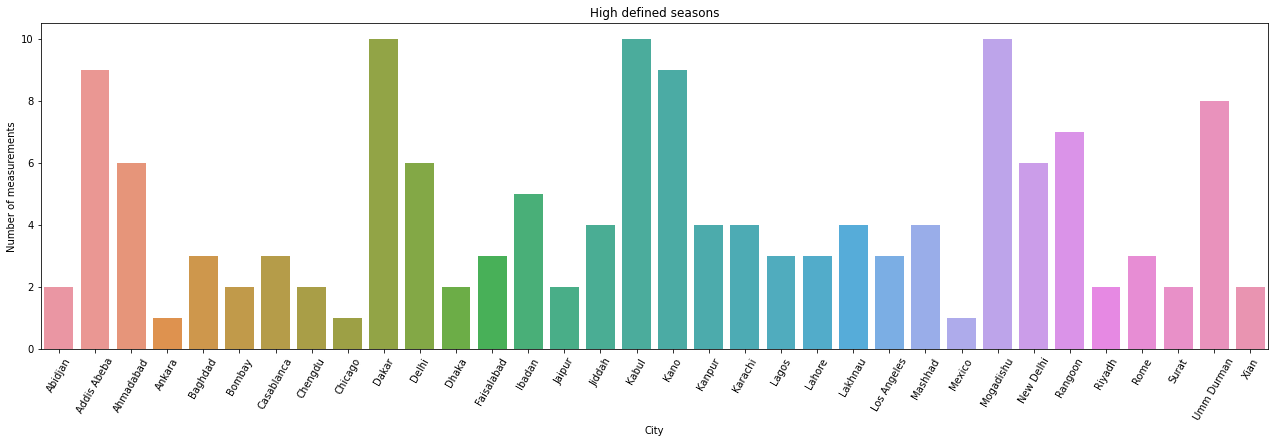

In [107]:
plt.figure(figsize=(22,6))

p = sns.countplot(x="City", data=df_stdtempsboreal_ts[df_stdtempsboreal_ts['TimeSeriesKMeansLabelStd'] == boreal_std_labels[1]])
p.set(ylabel='Number of measurements', title=boreal_std_labels[1])
p.set_xticklabels(p.get_xticklabels(), rotation = 60)

### Austral hemisphere<a name="austral-regions-std"></a>

[Text(0, 0, 'Belo Horizonte'),
 Text(1, 0, 'Brasília'),
 Text(2, 0, 'Cape Town'),
 Text(3, 0, 'Dar Es Salaam'),
 Text(4, 0, 'Durban'),
 Text(5, 0, 'Fortaleza'),
 Text(6, 0, 'Harare'),
 Text(7, 0, 'Jakarta'),
 Text(8, 0, 'Kinshasa'),
 Text(9, 0, 'Lima'),
 Text(10, 0, 'Melbourne'),
 Text(11, 0, 'Nairobi'),
 Text(12, 0, 'Rio De Janeiro'),
 Text(13, 0, 'Salvador'),
 Text(14, 0, 'Santiago'),
 Text(15, 0, 'Surabaya'),
 Text(16, 0, 'Sydney'),
 Text(17, 0, 'São Paulo')]

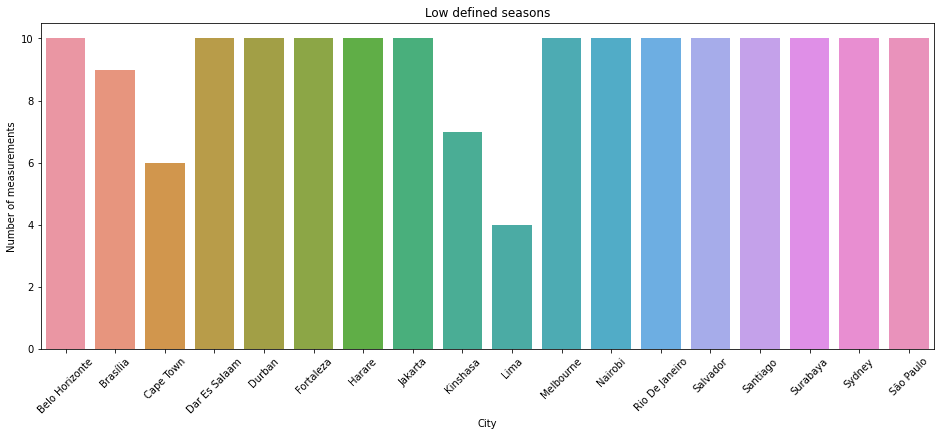

In [108]:
plt.figure(figsize=(16,6))

p = sns.countplot(x="City", data=df_stdtempsaustral_ts[df_stdtempsaustral_ts['TimeSeriesKMeansLabelStd'] == austral_std_labels[0]])
p.set(ylabel='Number of measurements', title=austral_std_labels[0])
p.set_xticklabels(p.get_xticklabels(), rotation = 45)

[Text(0, 0.5, 'Number of measurements'),
 Text(0.5, 1.0, 'High defined seasons')]

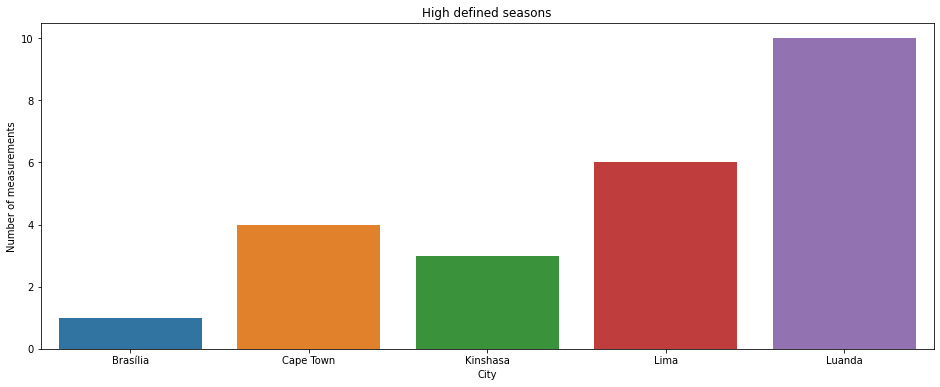

In [109]:
plt.figure(figsize=(16,6))

p = sns.countplot(x="City", data=df_stdtempsaustral_ts[df_stdtempsaustral_ts['TimeSeriesKMeansLabelStd'] == austral_std_labels[1]])
p.set(ylabel='Number of measurements', title=austral_std_labels[1])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bd0371f1-26bc-4fa2-b3a3-1a163a949e34' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>